# Towards A Principled Bayesian Workflow
_*Michael Betancourt*_<br>
_*October 2018*_

Given a probabilistic model and a particular observation, Bayesian inference is straightforward to implement.  Inferences, and any decisions based upon them, follow immediately in the form of expectations with respect to the corresponding posterior distribution.  Building a probabilistic model that is useful in a given application, however, is a far more open-ended challenge.  Unfortunately the process of model building is often ignored in introductory texts, leaving practitioners to piece together their own model building workflow from potentially incomplete or even inconsistent heuristics.

In this case study I introduce a _principled_ workflow for building
and evaluating probabilistic models in Bayesian inference.  This workflow is
based on recent research in collaboration with Dan Simpson, Aki Vehtari, Sean
Talts, and others; see, for example, Gabry et al. (2017).  The specific workflow
that I advocated here, however, is my particular take on this research that is 
focused on the needs of modeling and inference in the physical sciences.  It 
does not necessarily reflect the perspectives of any of my collaborators and may 
prove to be limiting in other applications.

Moreover, as this workflow is an active topic of research it is subject to
evolution and refinement. Use it at your own risk.  But at the same time _don't_
use at your own risk.  Better yet build a calibrated model, infer the relative
risks, and then make a principled decision...

We begin with a review of Bayesian inference and then a discussion of what 
properties we want in a probabilistic model and in what ways we can validate
those properties.  I then introduce a workflow that implements these validations
to guide the development of a useful model, emphasizing the role of each step 
and the expertise needed to implement them well.  Once the workflow has been 
laid out I demonstrate its application on a seemingly simple analysis that hides 
a few surprises.

# Bayesian Modeling and Inference

In order to avoid any confusion due to the varied notations and vocabularies 
that abound in the statistical literature, let's first review the foundational 
concepts in Bayesian inference.  Be aware that I'll be taking an experimental 
perspective here, and that perspective may clash with different philosophical 
perspectives on Bayesian inference, or statistics in general, that are often 
emphasized in introductory texts.  Fortunately, in most cases the differences 
between these perspectives don't have any consequences for how the resulting
inferences are implemented in practice.

Let's first consider some phenomenon about which we want to learn.  Further 
let's assume that this phenomenon manifests in some latent system with which we 
can interact.  Importantly, this latent system contains not only the phenomenon 
of interest but also the surrounding environment that exhibits the phenomenon.

In order to learn about this phenomenon we need to design an experiment that 
implements a _measurement process_.  The resulting measurements probes the 
latent system, generating data that is hopefully sensitive to the phenomenon of 
interest.  Note that I use the term experiment generally here to include also 
processes that collect, curate, and transform existing observations.  More 
formally we say that the realizations of the measurement process results is an 
_observation_, $\tilde{y}$, that is an element of an _observation space_, $Y$.

The measurement process however, is not deterministic.  There may be 
_ontological_ variability that results in different observations every time we 
probe the latent system, or _epistemic_ uncertainty that limits how accurately 
we can resolve the measurement.  Regardless of its interpretation, we presume
that this complication is sufficiently regular that it can be quantified in a
probability distribution over the observation space that we denote the _true 
data generating process_, $\pi^{\dagger}$.  Because of this limitation of the
measurement process, the best we can ultimately learn about the underlying 
latent system, and hence the phenomenon of interest, is this true data 
generating process.

Although we presume that a true data generating process exists, we don't know
what form it will take in a given application.  Unfortunately the space of all 
possible data generating processes, $\mathcal{P}$, is far too large and 
mathematically ungainly to consider, so in practice we have to limit our search 
to a _small world_, $\mathcal{S}$, or _observational model_ of possible data 
generating processes.  

<br><br>
![](figures/small_world/small_world/small_world.png)
<br><br>

Each element of the observational model, or each _model configuration_, defines 
a probability distribution over the observation space which quantifies a 
mathematical narrative of how the data could be generated, encapsulating the 
phenomenon of interest as well as any systematic phenomena encountered from the 
latent system through the measurement process.  We can then use the assumed
observational model to learn from observations, making inferences and informing 
decisions about the latent system that we're studying.  In practice we specify 
an observational model with a collection of probability densities, 
$\pi_{\mathcal{S}} (y ; \theta)$, with each _parameter_, $\theta$, identifying a unique
model configuration.

<br><br>
![](figures/model_config/model_config.png)
<br><br>

Bayesian inference encodes information about the observational model in
probability distributions -- the more probability a distribution assigns to a 
neighborhood of model configurations, the more consistent those model 
configurations are with our available information.  From this perspective the 
model configuration space is no longer just a collection of data generating 
processes but also a conditional probability distribution over the product 
of the observation space and the small world, $Y \times \mathcal{S}$,
$$
\pi_{\mathcal{S}}(y ; \theta) = \pi_{\mathcal{S}}(y \mid \theta).
$$

Introducing a _prior distribution_, $\pi_{\mathcal{S}}(\theta)$, that encodes 
domain expertise about the measurement process and latent system complements the 
observational model to give a _Bayesian joint distribution_,
$$
\pi_{\mathcal{S}}(y, \theta) = \pi_{\mathcal{S}}(y ; \theta) \, \pi_{\mathcal{S}}(\theta).
$$
Given the an explicit observation, $\tilde{y}$, this joint distribution then
defines a _posterior distribution_ that concentrates on those model
configurations consistent with both our domain expertise and the measurement,
$$
\pi_{\mathcal{S}}(\theta \mid \tilde{y}) = 
\frac{ \pi_{\mathcal{S}}(\tilde{y}, \theta) }{ \int \mathrm{d} \theta \, \pi_{\mathcal{S}}(\tilde{y}, \theta) }
\propto \pi_{\mathcal{S}}(\tilde{y}, \theta).
$$

We can also interpret this process as _updating_ the prior distribution into
a posterior distribution,
$$
\pi_{\mathcal{S}}(\theta \mid \tilde{y}) = \left( \frac{ \pi_{\mathcal{S}}(\tilde{y} \mid \theta) }
{ \pi_{\mathcal{S}}(\tilde{y}) } \right) \pi_{\mathcal{S}}(\theta),
$$ 
which makes the inherent learning process more evident.  Our information after 
the observation, encoded in the posterior, is just our information before the 
observation, encoded in the prior, plus the information we learn from the 
observation, encoded in the ratio
$$
\frac{ \pi_{\mathcal{S}}(\tilde{y}, \theta) }
{ \int \mathrm{d} \theta \, \pi_{\mathcal{S}}(\tilde{y}, \theta) }.
$$

<br><br>
![](figures/bayes/bayes.png)
<br><br>

Any inferential query we have can then be answered with an expectation value of
an appropriate function with respect to the posterior distribution.  For 
example, where in the small world the most consistent model configurations 
concentrate can be quantified with the mean or the median of the posterior 
distribution.  Similarly, the breadth of this concentration can be quantified 
with the standard deviation or tail quantiles of the posterior distribution.

# Questioning Authority

Given an observational model and a prior distribution, or equivalently the 
joint distribution, $\pi_{\mathcal{S}}(y, \theta)$, Bayesian inference is 
straightforward to implement.  At least conceptually,  The utility of any 
inferences we derive, however, are completely dependent on this assumed model.
A poor model might readily yield inferences, but those inferences may be of 
little use in practice and may even be dangerous in critical applications.

What, however, characterizes a useful probabilistic model?  Ideally the model 
would be consistent with our domain expertise, capturing not necessarily _all_ 
of our knowledge of the experimental design but just enough to admit answers to 
the scientific questions of interest.  It would also help if the model didn't 
obstruct our available computational tools so that we could accurately compute 
posterior expectation values and faithfully implement out inferences in 
practice.  Finally, we would hope that our model is rich enough to capture the 
structure of the true data generating process that is needed to answer our 
scientific questions.

Consequently we can verify the utility of a model in a given application by
trying to answer four questions.

#### Question One: Domain Expertise Consistency

_Is our model consistent with our domain expertise?_

#### Question Two: Computational Faithfulness

_Are our computational tools sufficient to accurately fit the model?_

#### Question Three: Model Sensitivity

_How do we expect our inferences to perform over the possible realizations of
the measurement process?_

#### Question Four: Model Adequacy

_Is our model rich enough to capture the relevant structure of the true data
generating process?_

These questions can be challenging to answer even in simple applications, but
with careful analysis of a given model we can assemble the necessary evidence to 
answer each of the four questions well enough to identify practical problems 
with the model.

## Domain Expertise Consistency 

A common refrain is to "let the data speak for itself".  In a statistical
analysis, however, the data speak only through the observational model, and the
observational model isn't always so talkative.

When the _likelihood function_, $\pi_{\mathcal{S}}(\tilde{y} \mid \theta)$, 
concentrates in a small neighborhood of parameter space the structure of the 
prior isn't particularly important.  The information we learn from the 
observation dominates the form of the posterior distribution.

<br><br>
![](figures/joint_triptych/joint_triptych_one/joint_triptych_one.png)
<br><br>

The observational model, however, isn't always so well-behaved.  Sometimes the
experimental design isn't sufficiently sensitive to the phenomena of interest,
which manifests in a _weakly-identified_ likelihood function that spans huge
regions of the model configuration space, or even a _non-identified_ likelihood
function that extends all the way to infinity.  In these cases the form of the
posterior is strongly influenced by the form of the prior, and a careless prior 
propagates to a careless posterior.

<br><br>
![](figures/joint_triptych/joint_triptych_two/joint_triptych_two.png)
<br><br>

In order to compensate for poor identification in the likelihood function we
need the prior distribution to incorporate just enough domain expertise to
suppress extreme, although not impossible, model configurations.

<br><br>
![](figures/joint_triptych/joint_triptych_three/joint_triptych_three.png)
<br><br>

That said, the success of a _weakly-informative prior_ like this depends on how 
the prior interacts with the likelihood function, and in sophisticated models 
these interactions can be difficult to analyze.  In practice it's often easiest 
to study how these interactions affect observations predicted by the model.

The _prior predictive distribution_,
$$
\pi_{\mathcal{S}}(y) = \int \mathrm{d} \theta \, \pi_{\mathcal{S}}(y, \theta),
$$
averages each data generating process within the observational model over the
prior distribution, quantifying the range of observations deemed reasonable
within the scope of our modeling assumptions.  A model predicting too many 
observations that are considered extreme within the scope of our domain
expertise then indicates conflict between the modeling assumptions and that 
domain expertise.

Analyzing the posterior predictive distribution, however, is not particularly
straightforward when the observation space is high-dimensional.  In this case 
we have to consider _summary statistics_ that project the observational space to 
some lower dimensional space that's more amenable to visualization, and hence 
practical comparison to our often implicit domain expertise.  For example we 
might project the observations to a one-dimensional summary, 
$t : Y \rightarrow \mathbb{R}$, or even a structured summary like a histogram or 
empirical cumulative distribution function.  Constructing an interpretable yet
informative summary statistic is very much a fine art.

Once a summary statistic has been chosen we can then identify which values
of the summary statistic correspond to observations that begin to become 
extreme.  For example, if we're observing how quickly a drug propagates through
a patient's blood stream we can be fairly confident that the observed 
propagation speed will be less than the speed of sound in water as a drug dose
traveling that fast would have unfortunately physical consequences.  Similarly,
if we're observing carbon in the air then we don't want our model predicting
carbon concentrations more characteristic of solid concrete than gaseous, 
breathable air.  If we're observing the migration of birds then we can be fairly 
sure that we won't observe any particularly healthy individuals cruising near 
the speed of light.  In practice these thresholds are readily identified with a 
cursory examination of the available domain expertise, especially if the summary 
statistics are well-chosen.

With summary statistics and thresholds in hand _prior predictive checks_
follow immediately.  We simply push the prior predictive distribution forward 
along each the summary statistic, the corresponding probability density function
$\pi_{t(Y)}(t)$ here show in dark red, and then consider how much 
probability leaks past the threshold and into the extreme values, here shown in 
light red.

<br><br>
![](figures/prior_predictive/prior_predictive_theory/prior_predictive_theory.png)
<br><br>

In practice we typically can't construct the probability density function for
this pushforward distribution analytically, but we can approximate it using 
samples from the joint distribution.  Sampling
$$
\tilde{\theta} \sim \pi_{\mathcal{S}}(\theta)
$$
$$
\tilde{y} \sim \pi_{\mathcal{S}}(y \mid \tilde{\theta})
$$
yields samples from the joint distribution, $(\tilde{y}, \tilde{\theta})$,
and evaluating the summary statistic at the simulated observations,
$$
t(\tilde{y})
$$
yields samples from the pushforward of the prior predictive distribution.  We
can then histogram these samples to implement the posterior predictive check.

<br><br>
![](figures/prior_predictive/prior_predictive_practice/prior_predictive_practice.png)
<br><br>

The model shouldn't predict _no_ observations past the thresholds -- extreme
observations are unreasonable but not impossible, after all.  Instead what we
want to look for is excessive predictions surpassing the thresholds, and this is 
a more qualitative than quantitative judgement.  Indeed visualizations of the 
pushforward distributions are a powerful way to elicit qualitative information 
from domain experts unfamiliar with statistics.  The emphasis on the observation 
space is often more interpretable than the configurations of a specific 
observational model.  Moreover, the emphasis on extremes allows those experts to 
reject bad assumptions, which they are often far more eager to do opposed to
accepting good assumptions.

The idea of analyzing the prior predictive distribution goes back to Good's 
_device of imaginary results_ (Good 1950), which conveniently also gives its 
user +2 to Wisdom saving throws.

## Computational Faithfulness

A model is only as good as our ability to wield it.  In Bayesian inference, a
model is only as good as our ability to compute expectation values with respect
to the posterior distributions it generates, which is often denoted _fitting_
the model.  Robust methods that offer a self-diagnostics capable of identifying 
inaccurate computation, such as Hamiltonian Monte Carlo, are extremely powerful 
in this regard as they provide some confidence that we can realize the 
inferences of our model.  

If these diagnostics are available then the prior predictive distribution 
proves further useful.  Fitting observations simulated from the prior predictive 
distribution allows us check the performance of our chosen computational method 
over the range of reasonable posterior distribution behaviors.

What can we do, however, if our method isn't self-diagnostic?  Fortunately
Bayesian inference implies a subtle consistency property that allows us to 
check _any_ method capable of generating posterior samples.  Averaging the
posterior distributions fit from observations drawn from the prior predictive 
distribution will _always_ recover the prior distribution,
$$
\pi_{\mathcal{S}}(\theta') = \int \mathrm{d} y \, \mathrm{d} \theta \,
\pi_{\mathcal{S}} (\theta' \mid y) \, \pi_{\mathcal{S}} (y, \theta).
$$
In particular this implies that the ensemble of posterior samples,
$$
\tilde{\theta} \sim \pi_{\mathcal{S}}(\theta)
$$
$$
\tilde{y} \sim \pi_{\mathcal{S}}(y \mid \tilde{\theta})
$$
$$
\tilde{\theta}' \sim \pi(\theta \mid \tilde{y}),
$$
will always be identical to samples from the prior distribution.  Any
deviation between the two samples indicates that either our model has been 
incorrectly implemented or our computational method is generating biased
samples.

_Simulated-based calibration_ (Talts et al. 2018) compares the ensemble posterior
sample and the prior sample using _ranks_.  For each simulated observation we
generate $R$ samples from the corresponding posterior distribution,
$$
\tilde{\theta} \sim \pi_{\mathcal{S}}(\theta)
$$
$$
\tilde{y} \sim \pi_{\mathcal{S}}(y \mid \tilde{\theta})
$$
$$
(\tilde{\theta}'_{1}, \ldots, \tilde{\theta}'_{R}) \sim \pi(\theta \mid \tilde{y}),
$$
and compute the rank of the prior sample within the posterior samples, i.e.
the number of posterior samples larger than the prior sample,
$$
\rho = \sharp \left\{ \tilde{\theta} < \tilde{\theta}'_{r} \right\}.
$$
If the ensemble posterior sample and the prior sample are equivalent then these
ranks should be uniformly distributed, which we can quickly analyze for each
parameter in the model configuration space using a histogram.

<br><br>
![](figures/sbc/sbc.png)
<br><br>

Here the grey band demonstrates the expected variation of ranks distributed 
according to an exact uniform distribution.  Deviation outside of these bands,
especially systematic deviation of many bins at once, indicates computational 
problems.  See Talts et al. (2018) for further discussion of common systematic 
deviations and their interpretations.

Technically this method requires exact posterior samples, which are not 
available if we using, for example, Markov chain Monte Carlo.  To use simulation
based calibration with Markov chain Monte Carlo we have to first thin our Markov 
chains to remove any effective autocorrelation.  See Talts et al. (2018) for more 
details.

## Model Sensitivity

The scope of reasonable observations and model configurations quantified in the 
Bayesian joint distribution also provides a way to analyze the range of 
inferential outcomes we should expect, and in particular _calibrate_ them with
respect to the simulated truths (Betancourt 2018).

For example, let's say that we have some _decision making process_ that takes in
an observation as input and returns an action from the space of possible 
actions, $A$,
$$
\begin{alignat*}{6}
a :\; &Y& &\rightarrow& \; &A&
\\
&y& &\mapsto& &a(y)&.
\end{alignat*}
$$
This process might be a Bayesian decision theoretical process informed by
posterior expectations, but it need not be.  It could just as easily be a
process to reject or accept a null hypothesis using an orthodox significance 
test.

Further let's say that the benefit of taking action $a \in A$ when the true
data generating process is given by the model configuration $\theta$ is
$$
\begin{alignat*}{6}
U :\; &A \times \mathcal{S}& &\rightarrow& \; &\mathbb{R}&
\\
&(a, \theta)& &\mapsto& &U(a, \theta)&.
\end{alignat*}
$$
For example this might be a false discovery rate or the benefits of an 
intervention minus any of its implementation costs.  In this context the utility 
of a decision making process for a given observation becomes  
$$
\begin{alignat*}{6}
U :\; &Y& &\rightarrow& \; &\mathbb{R}&
\\
&(y, \theta)& &\mapsto& &U(a(y), \theta)&.
\end{alignat*}
$$

Before the measurement process resolves we don't know what the observation will
be, nor do we know what the true data generating process will be.  If we 
assume that our model is rich enough to capture the true data generating 
process, however, then the joint distribution quantifies the possibilities.
Consequently we can construct the distribution of possible utilities by 
pushing the Bayesian joint distribution forward along the utility function to
give $\pi_{U(A, \mathcal{S})}$.

<br><br>
![](figures/sensitivity/sensitivity_theory/sensitivity_theory.png)
<br><br>

As with the prior predictive check, we can approximate the probability density 
function of this pushforward distribution in practice using samples from the 
joint distribution,
$$
\tilde{\theta} \sim \pi_{\mathcal{S}}(\theta)
$$
$$
\tilde{y} \sim \pi_{\mathcal{S}}(y \mid \tilde{\theta})
$$
$$
U(a(\tilde{y}), \tilde{\theta}).
$$

<br><br>
![](figures/sensitivity/sensitivity_practice/sensitivity_practice.png)
<br><br>

This distribution of utilities is particularly useful for understanding how
sensitive the measurement process is to the relevant features of the latent
system that we're studying.  By carefully quantifying what we want to learn in
the experiment into a utility function, we can formalize how capable our model
is at answering those questions.

We can also take a less application-specific approach and use the Bayesian joint 
distribution to characterize the general performance of our inferences and
capture any pathologies that might be lurking within the assumptions of our
model.

Consider, for example, the _posterior $z$-score_ of a given parameter in the
model configuration space,
$$
z = \left|
\frac{ \mu_{\mathrm{post}} - \tilde{\theta} }
{ \sigma_{\mathrm{post}} } \right|.
$$
The posterior $z$-score quantifies how accurately the posterior recovers the 
true model configuration, with smaller values indicating a posterior that
concentrates more tightly around the corresponding true parameter and larger
values indicating a posterior that concentrates elsewhere.

Similarly, the _posterior shrinkage_ of a given parameter,
$$
s = 1 -
\frac{ \sigma^{2}_{\mathrm{post}} }
{ \sigma^{2}_{\mathrm{prior}} },
$$
quantifies how much the posterior learns about that parameter from a given 
observation.  Posterior shrinkage near zero indicates that the data provide 
little information beyond the domain expertise encoded in the prior 
distribution, while posterior shrinkage near one indicates observations that 
strongly inform this parameter.

Conveniently, these two posterior expectations can capture an array of 
pathological behavior that typically compromises our inferences.  For example,
a posterior with high posterior shrinkage and high posterior $z$-score 
indicates a model that overfits to the variation in the measurement and is
unable to accurately recover the true model configuration.  A posterior with
small posterior shrinkage and small posterior $z$-scores indicates a model that
is poorly informed by the observations, where as a posterior with small 
posterior shrinkage and large posterior $z$-scores indicates a model with
substantial conflict between the observational model and the prior distribution.

If we fit the posterior for each observation in an ensemble of samples from
the Bayesian joint distribution,
$$
\tilde{\theta} \sim \pi_{\mathcal{S}}(\theta)
$$
$$
\tilde{y} \sim \pi_{\mathcal{S}}(y \mid \tilde{\theta}),
$$
then we can visualize the distribution of posterior $z$-scores and posterior 
shrinkages for each parameter,
$$
z(\pi_{S}(\theta_{n} \mid \tilde{y}), \tilde{\theta}_{n})
$$
$$
s(\pi_{S}(\theta_{n} \mid \tilde{y}), \pi_{S}(\theta_{n}))
$$
with a scatter plot of each posterior's behavior and quickly identify potential 
problems.

<br><br>
![](figures/eye_chart/eye_chart_regimes.png)
<br><br>

## Model Adequacy

Finally we can consider the adequacy of our model in capturing the relevant
structure of the true data generating process.

If our model is sufficiently rich then the small world might contain the true
data generating process and inferences within the small world might identify 
that true data generating process.  In practice, however, reality is much richer 
than any model we could feasibly implement and the small world is unlikely to
contain the true data generating process.

<br><br>
![](figures/small_world/small_world_one/small_world_one.png)
<br><br>

In this more realistic scenario the posteriors can't concentrate around the true
data generating process, and instead must be resort to concentrating around the
model configurations within the small world that best approximate the true data
generating process.

<br><br>
![](figures/small_world/small_world_two/small_world_two.png)
<br><br>

The pertinent question is then not whether or not our small world contains the
true data generating process but rather whether or not our small world is 
_close enough_ to the true data generating process.  To paraphrase George Box,
our model is probably wrong, but is it useful?

Consequently, in order to quantify the adequacy of our model we need to 
determine how close it is to the true data generating process, and in order to 
do that we need to summarize our inferences into a predictive distribution that 
we can directly compare to the true data generating process. For that we 
appeal to the _posterior predictive distribution_,
$$
\pi_{\mathcal{S}}(y \mid \tilde{y}) = \int \mathrm{d} \theta \, 
\pi_{\mathcal{S}}(\theta \mid \tilde{y}) \, \pi_{\mathcal{S}}(y \mid \theta),
$$
which averages all of the data generating process within the observational model 
over the posterior distribution, quantifying the range of predictions consistent 
with both our domain expertise and the observation, $\tilde{y}$.  

If we want to compare the whole of the posterior predictive distribution and the 
true data generating process, then some reasonable assumptions quickly lead us
to the _Kullback-Leibler divergence_, 
$\mathrm{KL}(\pi^{\dagger}(y) \mid \mid \pi_{\mathcal{S}}(y \mid \tilde{y}))$ 
(Betancourt 2015), which vanishes when the two distributions are identical and 
monotonically increases as they deviate.  

That said, in practice we can't compute this divergence without knowing the true 
data generating process!  Instead we have to _approximate_ the divergence using 
just our observed data, which ultimately yields Bayesian cross validation and 
the many information criteria that further approximate that.  Importantly in 
this series of approximations we lose the ability to estimate absolute 
divergences and instead can estimate only _differences_ between divergences from 
the posterior predictive distributions of different models.  This makes these 
approximations useful for model comparison, but not determining the adequacy of 
a single model in isolation.

Moreover, there's also a deeper issue with comprehensive measures like the 
Kullback-Leibler divergence between the posterior predictive distribution and
the true data generating process.  We know our model will not capture every 
intimate detail of reality, and we really only want our model to capture those
details relevant to our scientific goals.  If we're modeling bird migration then 
we don't have any need to model the irrelevant effects of quantum mechanics or 
general relativity!  Comprehensive measures, however, are often strongly 
affected by these irrelevant details, making it difficult to isolate the 
structures about which we do care.

Fortunately we've already thought about isolating the features of the 
observation space relevant to our scientific questions -- they're exactly what
motivated the summary statistics we would use for a prior predictive check!
Consequently we can reuse those summary statistics to construct _posterior
predictive checks_ that visually compare the pushforwards of the posterior 
predictive distribution, $\pi_{t(Y) \mid Y}(t \mid \tilde{y})$, to the observed
summary statistic, $t(\tilde{y})$.

If the observed summary statistic, here shown in light red, falls within the 
bulk of the pushforward distribution, here shown in dark red, then our model is
doing an adequate job of modeling the behaviors captured by the summary 
statistic.

<br><br>
![](figures/posterior_predictive/posterior_predictive_good/posterior_predictive_good.png)
<br><br>

If the observed summary statistic falls in the tails of the pushforward 
distribution, however, then the situation is not so clear.
<br><br>
![](figures/posterior_predictive/posterior_predictive_bad/posterior_predictive_bad.png)
<br><br>

Unfortunately we can't discriminate between our observation being a rare but not
impossible extreme and our model being insufficiently sophisticated to capture 
the relevant structure of the true data generating process that manifests in the 
summary statistic.  Instead we have to rely on our domain expertise to identify
possible _model expansions_ that could resolve this discrepancy without 
compromising our inferences if the discrepancy is just a mirage.

As with prior predictive checks, in practice we typically can't construct the 
probability density function for these pushforward distributions analytically 
in order to implement a posterior predictive check.  We can, however, readily
approximate it with samples from the posterior predictive distribution,
$$
\tilde{y}' \sim \pi_{\mathcal{S}}(\theta \mid \tilde{y}),
$$
on which we can then evaluate our summary statistics, 
$$
t(\tilde{y}')
$$
to give samples from the pushforwards of the posterior predictive distribution.

<br><br>
![](figures/posterior_predictive/posterior_predictive_practice/posterior_predictive_practice.png)
<br><br>

Posterior predictive checks date back to Rubin (1984) and the beginnings of 
the simulation revolution in statistics.

# Building a Mystery

If there are no indications that a given model is failing any of these four
questions then we can proceed to apply it in practice confident that it will
provide reasonably robust inferences for the relevant scientific goals.  If 
there are signs of trouble for any of these four questions, however, then we
have to consider improving the model, or occasionally even reducing the 
ambition of our scientific questions in the first place.

The goal of a principled Bayesian workflow is to guide a practitioner through 
a regimented model critique that addresses these four questions.  In particular
any criticisms need to be _interpretable_ in order to inform the practitioner 
how to improve the analysis and address those criticisms.  This feedback then
further guides iterative model development that converges to a model capable of
tackling the relevant scientific goals.

A robust model development is initialized with a conceptual analysis of the
model that a practitioner would fit without the practical limitations of finite
computational resources, time, and mathematical tools.  This _aspirational 
model_, $\mathcal{S}_{A}$, would incorporate all of the systematic effects that 
might influence the measurement process, such as heterogeneity across 
individuals or variation across space and time, and richer structure than 
typically presumed in the phenomenological models often used in practice.  It
would also incorporate all of the domain expertise available within a field.
Reasoning about the aspirational model forces practitioners to reason about the 
subtleties in the latent system being studied and the measurement process being 
used to probe that system.

Within this abstract aspirational model we then explicitly build our initial 
model, $\mathcal{S}_{1}$, to be just sophisticated enough to incorporate the 
phenomena of scientific interest but no more.  This initial model typically 
includes few if any systematic effects and only as much domain expertise as 
needed to motivate an initial prior distribution.

<br><br>
![](figures/asp_simple/asp_simple.png)
<br><br>

The aspirational model provides critical context for this initial model.  In
particular, the _difference_ between the two models, 
$\mathcal{S}_{A} \setminus \mathcal{S}_{1}$, encapsulates all of the potentially
relevant structure ignored by the initial model.

<br><br>
![](figures/asp_simple_diff/asp_simple_diff.png)
<br><br>

This abstract difference then motivates principled summary statistics that 
isolate these ignored structures, providing the foundations of constructive
prior and posterior predictive checks for the initial model.

If the initial model proves inadequate then we have to improve it, and the
context of the aspirational model guides that improvement so that we're not
adding arbitrary complexity irrelevant to our scientific goals.  In particular,
posterior predictive checks based on interpretable summary statistics 
immediately suggest the structure isolated by those summary statistics, such as
heterogeneity or time dependence in the observational model or domain expertise
neglected by the prior distribution.  Adding this structure yields an expanded
model, and if that expanded model still proves inadequate then we iterate, 
sequentially expanding our model until it becomes capable of achieving our 
scientific goals.  

<br><br>
![](figures/model_expansion/model_expansion.png)
<br><br>

By reasoning about the aspirational model first we don't randomly walk through
the space of all possible models but rather take coherent steps from our simple
initial model towards the aspirational model.

The emphasis on model _expansion_ is critical.  By subsuming the previous model
a new model can always fall back to the previous model configurations if the
added structure isn't actually helpful in explaining the true data generating
process.  Moreover, quantifying our inferences with an entire posterior
distribution, as opposed to say a point estimate of a single model 
configuration, ensures that the initial model configurations continue to
influence our inferences so long as they remain consistent with the 
observations.  This makes our model development workflow particularly robust to
the faux pas of rushing towards unneeded complexity and overfitting, especially 
when equipping each expanded model with priors distribution that incorporate the 
qualitative features of _penalized complexity priors_ that favor the previous 
model (Simpson et al. 2017).

Finally it's important to recognize that a better model is not always sufficient
to obtain the answers we want.  Sometimes our initial scientific goals are too 
ambitious, or our experiment is too insensitive to the phenomena of interest. 
In these cases a useful workflow will also identify the limitations of the 
measurement process and suggest more realistic goals for the available data.

# Work it, Make it, Do it, Makes Us Harder, Better, Faster, Stronger

Putting this all together we can now design a principled Bayesian workflow that
guides the development of robust models in practical applications.  The
workflow introduced here begins by examining the experimental design and the
resulting measurement process.  Only once the measurement process is understood
do we build our initial model and study its performance in the context of our
statistical and domain expertise.  Finally we can analyze the fit of the model
on the observed data, verifying the computational accuracy of the fit and the 
adequacy of the model to capture the relevant features of the true data 
generating process.  At any point we might identify failures which motivate 
improved models for which the workflow restarts.

Here _domain expertise_ refers to the experience of those responsible for
collecting, curating, or otherwise manipulating the data, as well as 
stakeholders who will make decisions using the final inferences or any 
intermediaries who will help stakeholders to make those decisions.  _Statistical 
expertise_ refers to proficiency in probabilistic modeling and computation.

## Experimental Design

Before modeling anything we need to first consider the design of our experiment, 
especially in the context of our scientific goals.  

### Step One: Conceptual Analysis

We begin by developing a conceptual understanding of the measurement process 
from the latent phenomena of interest through its interactions with the 
environment and how those interactions manifest as observations.  This
interaction then needs to be contrasted with our scientific goals in order to 
qualify how sensitive the observations are to the desired scientific phenomena.
Moreover, we want to pay particular attention to the many possible systematic 
effects that influence this process but are not known with complete certainty.  

This conceptual analysis yields informal narratives describing how observations 
are generated, forming the basis of the aspirational model to which all of our
explicit models will yearn to be when they grow up.

**Requirements:** Domain Expertise

### Step Two: Define Observations

Given our conceptual understanding of the measurement process we can take our 
first steps towards building a formal mathematical model by defining the space 
in which observations take values.  This may include, for example, the number of 
repetitions, subjects, groups, or components in each observation as well as the 
range of values each component can take.

**Requirements:** Domain Expertise and Statistical Expertise

### Step Three: Identify Relevant Summary Statistics

With an observation space formally defined we can begin to construct summary 
statistics that isolate relevant properties of the experimental design, 
especially those properties that influence decision making and those that we 
expect to be difficult to model and hence unlikely to be adequately described
by our early models.  These summary statistics provide then provide the basis 
for answering [Question One](#Question-One:-Domain-Expertise-Consistency) and 
[Question Four](#Question-Four:-Model-Adequacy).

In preparation for prior predictive checks we also want to complement these 
summary statistics with conceptual expectations for what behaviors are 
reasonable, or, as is often easier to elicit in practice, what behaviors are 
_unreasonable_.

**Requirements:** Domain Expertise

## Modeling

Once the experimental design has been fully considered we can begin the
modeling process in earnest.  Before we utilize any observed data we want to 
ensure that our model holds steadfast under the scrutiny of 
[Question One](#Question-One:-Domain-Expertise-Consistency), [Question Two](#Question-Two: Computational-Faithfulness), and
[Question Three](#Question-Three:-Model-Sensitivity).

### Step Four: Build a Model 

A Bayesian model requires an observation model, 
$\pi_{\mathcal{S}}(y \mid \theta)$, comprised of possible data generating 
processes and a prior model, $\pi_{\mathcal{S}}(\theta)$, that encodes selected 
domain expertise.  As our models grow in sophistication, however, the 
distinction between these two components is not always clear and so it is 
prescient to focus more on building the Bayesian joint distribution.

When first beginning the model development process our initial model should be 
as simple as possible, perhaps ignoring many if not all of the systematic 
effects of the environment in which the system of interest is contained.  The
initial model should be just sophisticated enough to be able to answer the 
scientific questions of interest in an idealized experiment.

#### Build an Observational Model

The observational model is built from many probability distributions over the 
observation space, each defining a mathematical narrative of how observations
are generated.  This collection of data generating processes should translate 
the conceptual narrative produced in [Step One](#Step-One:-Conceptual-Analysis) into a more 
rigorous probabilistic model.

Often the observational model is a crude approximation to the complexity of the 
true measurement process, but even crude approximations can be sufficient to 
answer sophisticated questions in practice.  Still, we want to keep the
approximate nature of our observational model, in particular the natural 
extensions of the model to include for example heterogeneities, time
dependences, and other systematic effects, in mind.

**Requirements:** Domain Expertise and Statistical Expertise

#### Complete The Model With Prior Distributions

In a Bayesian model the observational model is complemented with a prior 
distribution over the space of  all unknown model configuration parameters,
$\pi_{\mathcal{S}}(\theta)$.  The prior distribution does not need to 
incorporate all of our available domain expertise, just enough to ensure that 
the joint model,
$$
\pi_{\mathcal{S}}(y, \theta) 
= 
\pi_{\mathcal{S}}(y \mid \theta) \, \pi_{\mathcal{S}}(\theta),
$$
is well-behaved (Gelman, Simpson, and Betancourt 2017).  In practice it is often sufficient for the prior distribution to incorporate information about the _scales_, _units_, or _orders of magnitude_ which identify unreasonable but not impossible model configurations.

Keep in mind that the separation of the Bayesian model into an observation
model and a prior model is not uniquely defined.  Consider, for example, 
unobserved latent structure, $\pi_{\mathcal{S}}(\theta \mid \phi)$, such as that 
arising in hierarchical models and hidden Markov models. We could equally well 
define the observation model as 
$\pi_{\mathcal{S}}(y \mid \theta) \, \pi_{\mathcal{S}}(\theta \mid \phi)$ with 
the corresponding prior distribution $\pi_{\mathcal{S}}(\phi)$, or the 
observation model as $\pi_{\mathcal{S}}(y \mid \theta)$ with the prior 
distribution $\pi_{\mathcal{S}}(\theta \mid \phi) \, \pi_{\mathcal{S}}(\phi)$.  
Which is more appropriate in a given application depends on what parameters one 
expects to vary in the generation of new observations.

Consequently the focus should be not on specifying prior distributions in
isolation but rather _completing_ the observation model developed
[above](#Build-an-Observational-Model) with necessary domain expertise about the model
configurations.  This might take the form of independent, one-dimensional prior 
distributions for each parameter or more sophisticated prior distributions that
incorporate multiple parameters.  These joint priors often introduce their own 
parameters that require another round of prior distributions.  When building 
sophisticated models it's probability distributions all the way down.

**Requirements:** Domain Expertise and Statistical Expertise

### Step Five: Identify New Summary Statistics

Once a we have developed an explicit model we can reevaluate the context of
the aspirational model and modify existing summary statistics or introduce new
ones.  

If the current model is an expansion from a previous model then we can also 
take this opportunity to exploit any information from failures of the previous
model or information about added features to motivate new summary statistics. 
For example, if we add a new systematic effect then we might also introduce 
summary statistics that are sensitive to the heterogeneity of that systematic 
effect across configurations of the experiment, such as which individual 
collecting the data or at which site the data were collected.

### Step Six: Analyze the Joint Ensemble

Before considering any observed data we first want to understand the 
consequences of our modeling assumptions by answering 
[Question One](#Question-One:-Domain-Expertise-Consistency), [Question Two](#Question-Two: Computational-Faithfulness), 
and [Question Three](#Question-Three:-Model-Sensitivity).

Fortunately this analysis is readily performed with samples of reasonable
model configurations and observations from the joint distribution, 
$\pi_{\mathcal{S}}(y, \theta)$.  Typically we first simulate model configurations 
from the prior distribution and then observations from the corresponding 
data generating process,
$$
\tilde{\theta} \sim \pi_{\mathcal{S}}(\theta)
$$
$$
\tilde{y} \sim \pi_{\mathcal{S}}(y \mid \tilde{\theta} ),
$$
although when the separation between observational and prior models isn't so
clear we can consider any means of sampling from the joint distribution.

**Requirements:** Statistical Expertise

#### Analyze the Prior Predictive Distribution

Answers to [Question One](#Question-One:-Domain-Expertise-Consistency) are readily informed with prior
predictive checks of the summary statistics constructed in 
[Step Three](#Step-Three:-Identify-Relevant-Summary-Statistics) or [Step Five](#Step-Five:-Identify-New-Summary-Statistics).

If the prior predictive checks indicate conflict between the model and our 
domain expertise then we have to return to [Step Four](#Step-Four:-Build-a-Model) and 
modify our model, typically by incorporating additional domain expertise to 
better constrain [the prior distribution](#Complete-The-Model-With-Prior-Distributions).

**Requirements:** Domain Expertise

#### Evaluate Simulated Fits

For each simulated observation we can also construct a posterior distribution
with a given computational method, $\pi_{\mathcal{S}}(\theta \mid \tilde{y})$, 
or at least attempt as much.  In particular, the distribution of reconstructed 
posteriors allows to evaluate the accuracy of the computational method, 
answering [Question Two](#Question-Two: Computational-Faithfulness).

If the designated computational method features diagnostics, such as $\hat{R}$ 
for Markov chain Monte Carlo in general and divergences for Hamiltonian Monte 
Carlo in particular, then we can look for failed diagnostics across the 
distribution of posterior fits.  Failures indicate that we need to consider 
improving the tuning or implementation the computational method, or selecting 
another method altogether, and then repeating the fits.  

Correlating failed diagnostics with the corresponding simulated model 
configurations can also help to identify regions of the model configuration 
space that may be ill-posed for practical computation.  Moreover, the emergence 
of these pathological fits implies extreme behavior in the posterior which often 
hints at tension between the model and our domain expertise that may require 
reevaluating [Step Four](#Step-Four:-Build-a-Model).

**Requirements:** Statistical Expertise

#### Implement Simulated-Based Calibration

Even if our chosen computational method doesn't have its own diagnostics, we 
can evaluate its performance by performing simulation-based calibration over the
joint sample.  As above, if the performance of the method is unsatisfactory then 
we need to consider retuning the method, or selecting another method altogether 
and then repeating the fits.

**Requirements:** Statistical Expertise

#### Analyze General Model Sensitivity

Once we trust the faithfulness of our reconstructed posterior distributions we
can consider the breadth of inferences they provide to answer 
[Question Three](#Model-Sensitivity).  In general we can always consider the 
distribution of posterior $z$-scores against posterior shrinkages to identify 
common pathologies in our inferences.

If there are indications of undesired behavior, such as overfitting or
non-identifiability, then we might need to return to [Step One](#Step-One:-Conceptual-Analysis) 
to reconsider an improved experimental design or tempered scientific goals.  
Sometimes we may need only return to [Step Four](#Step-Four:-Build-a-Model) to
incorporate additional domain expertise that stabilizes our inferences.

**Requirements:** Statistical Expertise

#### Analyzing Bespoke Model Sensitivity 

If a decision-making process has been established then we can also calibrate the 
performance of this process by constructing the distribution of utilities over
the joint distribution.  For example, if a discovery claim is to be made then we 
at the very least want to compute the corresponding false discovery rates and 
true discovery rates within the context of our model.

Once again, if the calibration proves unsatisfactory then we will need to 
return to either [Step One](#Step-One:-Conceptual-Analysis) or [Step Four](#Step-Four:-Build-a-Model).

**Requirements:** Domain Expertise and Statistical Expertise

## Inference

If [Question One](#Question-One:-Domain-Expertise-Consistency), [Question Two](#Question-Two: Computational-Faithfulness), 
and [Question Three](#Question-Three:-Model-Sensitivity) have been satisfactorily answered
within the scope of the model then we can proceed to fitting the observed data 
and confront [Question Four](#Question-Four:-Model-Adequacy).  Once we consider the observed
data we introduce a vulnerability to overfitting and so we must be extremely 
vigilant to study the behavior of an expanded models in subsequent iterations of 
the workflow.

### Step Seven: Fit the Observations and Evaluate

Confident in our model we can construct a posterior distribution from the 
observed data.  We have to be careful, however, as the previous validation of 
our chosen computational method may not apply if the observed data is not within 
the scope of the prior predictive distribution, which can happen when the model
is too simple to capture the relevant structure of the true data generating
process.  Consequently we need to be careful to check any diagnostics of our 
method on the fit of the observed data.

If any diagnostics indicate poor performance then not only is our computational
method suspect but also our model may not be rich enough to capture the relevant 
details of the observed data.  At the very least we should reconsider the tuning 
of our computational tool, but we may also want to consider a deeper 
investigation into the poor performance to better identify the source of the
pathology.  This analysis can suggest limitations of our model which can 
motivate improvements in [Step Four](#Step-Four:-Build-a-Model).

**Requirements:** Statistical Expertise

### Step Eight: Analyze the Posterior Predictive Distribution

When we construct a posterior distribution for the observed data we can also
perform a posterior predictive check for each of our summary statistics to
answer [Question Four](#Question-Four:-Model-Adequacy).  If there are indications of 
problems then we need to go back to [Step Four](#Step-Four:-Build-a-Model) and expand the 
model as motivated by the interpretation of the summary statistic.  We may even 
need to go back to [Step One](#Step-One:-Conceptual-Analysis) and improve our domain expertise 
of the experimental design before considering an expanded model.  Once we have a 
new model we then restart the workflow and iterate until we can't identify any 
substantial deviations between the observed data and our fit.

In order to avoid biasing our model development by overfitting to the observed 
data, we have to be careful to not abuse the particular realization of the 
observed data.  Specifically we don't want to respond to failing posterior 
predictive checks by incorporating quantitative features of the observed data 
into the model but rather by expanding the model within the scope of our, 
possibly improved, domain expertise.  Failures of posterior predictive checks 
should motivate expansions of the model but not particular model configurations 
within that expanded model!

For example, we don't want to respond to a failing posterior predictive check by 
adding a new component to our model with particular values to match the observed 
data but rather a new component with uncertain values that are instead fit 
jointly with the rest of the model parameters.  The prior distribution for this 
new component should not be informed by the observed data but rather our domain 
expertise.

**Requirements:** Domain Expertise and Statistical Expertise

# Close Enough For An Effective Demonstration

In order to demonstrate this proposed workflow let's a consider a relatively
simple example of an analysis that might arise in any science lab.  We have
been tasked with analyzing data collected by a precocious young student who was
instructed to train a aim of detectors onto a radioactive specimen that emits a 
constant flow of particles.  They dutifully collected data and collated it into 
a file which has arrived in our inbox.

Before even reading the email we dutifully set up our local `Python` environment.

In [1]:
import matplotlib
import matplotlib.pyplot as plot
import numpy
import scipy.stats as stats
import multiprocessing
import math

import pystan
import stan_utility

light="#DCBCBC"
light_highlight="#C79999"
mid="#B97C7C"
mid_highlight="#A25050"
dark="#8F2727"
dark_highlight="#7C0000"
green="#00FF00"

## First Iteration: A Journey of a Thousand Models Begins with a Single Step

In our first iteration through the workflow we model the experiment that we've
been told occurred.  Nothing ominous here.

### Step One: Conceptual Analysis

Our conceptual model follows the instructions given to the student.  100
detectors were directed towards the source and set to record the number of
incident particles over a given interval of time.  The intensity of the source
is presumed to be constant over that interval and each detector should be
identical in operation.

### Step Two: Define Observations

Mathematically our observation takes the form of integer counts, $y$, for each
of the $N = 100$ detectors.  In the Stan modeling language this is specified as

In [2]:
with open('fit_data.stan', 'r') as file:
    lines = file.readlines()[0:4]
    for line in lines:
        print(line),

data {
  int N;    // Number of observations
  int y[N]; // Count at each observation
}


### Step Three: Identify Relevant Summary Statistics

There are $N = 100$ components in each observation, one for each detector.  We
could analyze each component independently but, because we have assumed that the
detectors are all identical, we can analyze their comprehensive responses with
a histogram of their counts.  In other words we consider the histogram of
detector counts _as the summary statistic_!

It's always difficult to create examples that incorporate domain expertise as 
the presentation of domain expertise that resonates with a given practitioner
will vary from field to field.  For this example we'll fake it with my 
explicitly decreeing the available expertise.  In particular, we assume that our 
conceptual domain expertise would inform us that 25 counts in a detector would 
be an extreme but not impossible observation for this kind of detector.

### Step Four: Build a Model

The constant intensity of the source and detector response suggest a Poisson
observation model for each of the detectors with a single source strength,
$\lambda$.

Our domain expertise that 25 counts is extreme suggests that we want our prior
for $\lambda$ to keep most of its probability mass below $\lambda = 15$, which
corresponds to fluctuations in the observations around
$15 + 3 \sqrt{15} \approx 25$.  We achieve this with a half-normal prior with
standard deviation = 6.44787 such that only 1% of the prior probability mass is
above $\lambda = 15$.

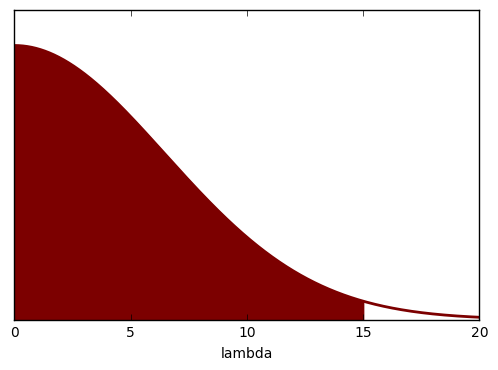

In [3]:
ls = numpy.arange(0, 20, 0.001)
pdfs = [ stats.norm.pdf(l, 0, 6.44787) for l in ls]
plot.plot(ls, pdfs, linewidth=2, color=dark_highlight)

ls = numpy.arange(0, 15, 0.001)
pdfs = [ stats.norm.pdf(l, 0, 6.44787) for l in ls]
plot.fill_between(ls, 0, pdfs, color=dark_highlight)

plot.gca().set_xlabel("lambda")
plot.gca().set_ylabel("Prior Density")
plot.gca().axes.get_yaxis().set_visible(False)
plot.show()

This probabilistic model is implemented in the Stan programs

In [4]:
with open('sample_joint_ensemble.stan', 'r') as file:
    print(file.read())

data {
  int N;
}

generated quantities {
  // Simulate model configuration from prior model
  real<lower=0> lambda = fabs(normal_rng(0, 6.44787));
  
  // Simulate data from observational model
  int y[N];
  for (n in 1:N) y[n] = poisson_rng(lambda);
}



In [5]:
with open('fit_data.stan', 'r') as file:
    print(file.read())

data {
  int N;    // Number of observations
  int y[N]; // Count at each observation
}

parameters {
  real<lower=0> lambda; // Poisson intensity
}

model {
  lambda ~ normal(0, 6.44787); // Prior model
  y ~ poisson(lambda);         // Observational model
}



### Step Five: Identify New Summary Statistics

The independent, identically distributed Poisson model is well suited by the
histogram summary statistic that we've already introduced.  

Were this model more complex then we might consider summary statistics that
exploit the specific structure of the model.  For example, were there variation 
in the Poisson intensity across groups we might consider separate histograms for 
the data arising from each of those groups.  

### Step Six: Analyze the Joint Ensemble

Here we will consider $R = 1000$ draws from the joint ensemble, each of
which simulates a ground truth and observed values for the $N = 100$ detectors.
Note the use of the `Fixed_param` algorithm in `Stan` which only evaluates the
`generated quantities` block at each iteration.

In [6]:
R = 1000 # 1000 draws from the Bayesian joint distribution
N = 100

simu_data = dict(N = N)

model = stan_utility.compile_model('sample_joint_ensemble.stan')
fit = model.sampling(data=simu_data,
                     iter=R, warmup=0, chains=1, refresh=R,
                     seed=4838282, algorithm="Fixed_param")

simu_lambdas = fit.extract()['lambda']
simu_ys = fit.extract()['y'].astype(numpy.int64)

Using cached StanModel


More draws from the joint ensemble will yield a more precise understanding
of the model and I recommend that you run as many replications as your
computational resources allow.  In circumstances with limited computational
resources even a few replications can provide a powerful view into the
consequences of your model.

#### Analyze the Prior Predictive Distribution

Each simulated observation in the joint ensemble gives a summary histogram.
For example, one sample gives the histogram

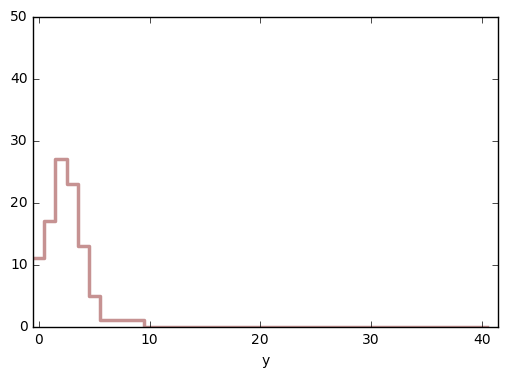

In [7]:
max_y = 40
B = max_y + 1

bins = [b - 0.5 for b in range(B + 1)]

idxs = [ idx for idx in range(B) for r in range(2) ]
xs = [ idx + delta for idx in range(B) for delta in [-0.5, 0.5]]

counts = [numpy.histogram(simu_ys[r], bins=bins)[0] for r in range(R)]

plot.plot(xs, [counts[0][idx] for idx in idxs], linewidth=2.5, color=dark, alpha=0.5)
plot.gca().set_xlim(-0.5, B + 0.5)
plot.gca().set_xlabel("y")
plot.gca().set_ylim(0, 50)
plot.show()

Three samples give the three histograms 

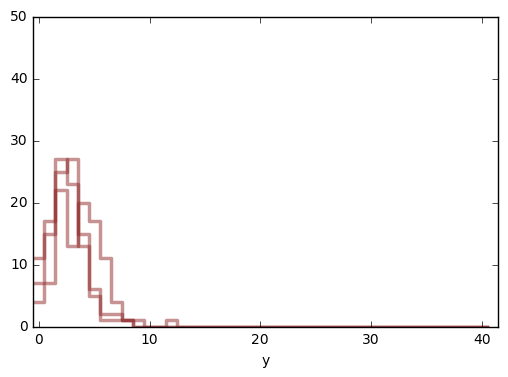

In [8]:
plot.plot(xs, [counts[0][idx] for idx in idxs], linewidth=2.5, color=dark, alpha=0.5)
plot.plot(xs, [counts[1][idx] for idx in idxs], linewidth=2.5, color=dark, alpha=0.5)
plot.plot(xs, [counts[2][idx] for idx in idxs], linewidth=2.5, color=dark, alpha=0.5)
plot.gca().set_xlim(-0.5, B + 0.5)
plot.gca().set_xlabel("y")
plot.gca().set_ylim(0, 50)
plot.show()

and ten samples give the ten histograms

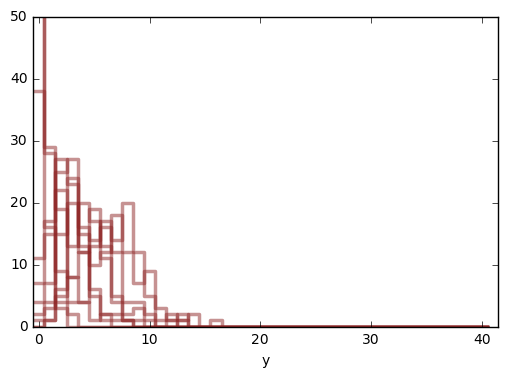

In [9]:
for n in range(10):
  plot.plot(xs, [counts[n][idx] for idx in idxs], linewidth=2.5, color=dark, alpha=0.5)
plot.gca().set_xlim(-0.5, B + 0.5)
plot.gca().set_xlabel("y")
plot.gca().set_ylim(0, 50)
plot.show()

We can visualize the entire prior predictive distribution of these histogram 
with quantiles of the bin counts.  Here the darkest red corresponds to the bin 
medians with the increasingly lighter bands corresponding to $(0.4, 0.6)$, 
$(0.3, 0.7)$, $(0.2, 0.8)$, and $(0.1, 0.9)$ intervals, respectively.  This 
visualization can obscure correlations amongst the bins, but it serves as a 
useful summary of the full prior predictive distribution.

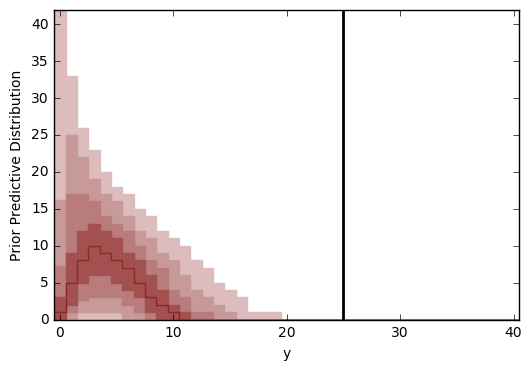

In [10]:
probs = [10, 20, 30, 40, 50, 60, 70, 80, 90]
creds = [numpy.percentile([count[b] for count in counts], probs)
         for b in range(B)]
pad_creds = [ creds[idx] for idx in idxs ]

plot.fill_between(xs, [c[0] for c in pad_creds], [c[8] for c in pad_creds],
                  facecolor=light, color=light)
plot.fill_between(xs, [c[1] for c in pad_creds], [c[7] for c in pad_creds],
                  facecolor=light_highlight, color=light_highlight)
plot.fill_between(xs, [c[2] for c in pad_creds], [c[6] for c in pad_creds],
                  facecolor=mid, color=mid)
plot.fill_between(xs, [c[3] for c in pad_creds], [c[5] for c in pad_creds],
                  facecolor=mid_highlight, color=mid_highlight)
plot.plot(xs, [c[4] for c in pad_creds], color=dark)

plot.gca().set_xlim([min(bins), max(bins)])
plot.gca().set_xlabel("y")
plot.gca().set_ylim([0, max([c[8] for c in creds])])
plot.gca().set_ylabel("Prior Predictive Distribution")

plot.axvline(x=25, linewidth=2.5, color="white")
plot.axvline(x=25, linewidth=2, color="black")

plot.show()

We see a very small prior predictive probability for observations above
the extreme scale informed by our domain expertise, which is corroborated by
the estimated tail probability,

In [11]:
float(len([ y for y in simu_ys.flatten() if y > 25 ])) / len(simu_ys.flatten())

0.00127

#### Evaluate Simulated Fits

Now we are ready to fit posteriors and draw inferences from each of our
replications.  Because each replication can be analyzed independently this
analysis is embarrassingly parallel which allows us to exploit the increasingly
common parallel computing resources.

Because this particular model can be fit so quickly I am parallelizing over
replications and not parallelizing the four Markov chains run to fit each
replication to which `Stan` defaults.  The optimal setup in any given analysis 
will depend on the details of the computational circumstances.

For each fit we capture the fit diagnostics, the simulation-based calibration
rank, and the posterior $z$-score and posterior shrinkage.

In [12]:
simus = zip(simu_lambdas, simu_ys)
fit_model = stan_utility.compile_model('fit_data.stan')

def analyze_simu(simu):
    simu_l = simu[0]
    simu_y = simu[1]
    
    # Fit the simulated observation
    input_data = dict(N = N, y = simu_y)
    
    fit = fit_model.sampling(data=input_data, seed=4938483, n_jobs=1)
    
    # Compute diagnostics
    warning_code = stan_utility.check_all_diagnostics(fit, quiet=True)
    
    # Compute rank of prior draw with respect to thinned posterior draws
    thinned_l = fit.extract()['lambda'][numpy.arange(0, 4000 - 7, 8)]
    sbc_rank = len(list(filter(lambda x: x > simu_l, thinned_l)))
    
    # Compute posterior sensitivities
    summary = fit.summary(probs=[0.5])
    post_mean_l = [x[0] for x in summary['summary']][0]
    post_sd_l = [x[2] for x in summary['summary']][0]
    
    prior_sd_l = 6.44787
    
    z_score = (post_mean_l - simu_l) / post_sd_l
    shrinkage = 1 - (post_sd_l / prior_sd_l)**2
    
    return [warning_code, sbc_rank, z_score, shrinkage]

Using cached StanModel


In [13]:
pool = multiprocessing.Pool(4)
ensemble_output = pool.map(analyze_simu, simus)

The first thing we do is check the diagnostics to make sure that each fit is
accurately representing the corresponding posterior distribution.

In [14]:
warning_codes = [x[0] for x in ensemble_output]
if sum(warning_codes) is not 0:
    print ("Some posterior fits in the generative " +
           "ensemble encountered problems!")
    for r in range(R):
        if warning_codes[r] is not 0:
            print('Replication {} of {}'.format(r, R))
            print('Simulated lambda = {}'.format(simu_lambdas[r]))
            stan_utility.parse_warning_code(warning_codes[r])
            print("")
else:
    print ("No posterior fits in the generative " +
           "ensemble encountered problems!")

No posterior fits in the generative ensemble encountered problems!


Fortunately there are no signs of any problems.

#### Implement Simulated-Based Calibration

We can provide an even stronger guarantee that our fits are accurate by applying
simulation-based calibration.

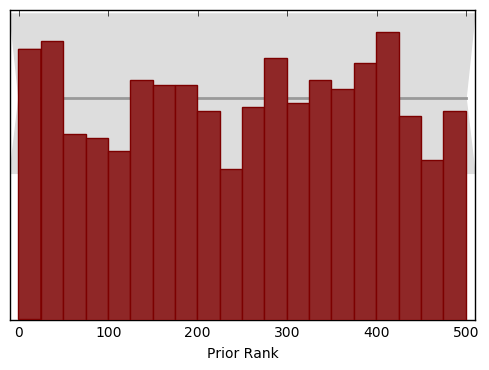

In [15]:
sbc_low = stats.binom.ppf(0.005, R, 25.0 / 500)
sbc_mid = stats.binom.ppf(0.5, R, 25.0 / 500)
sbc_high = stats.binom.ppf(0.995, R, 25.0 / 500)

bar_x = [-10, 510, 500, 510, -10, 0, -10]
bar_y = [sbc_high, sbc_high, sbc_mid, sbc_low, sbc_low, sbc_mid, sbc_high]

plot.fill(bar_x, bar_y, color="#DDDDDD", ec="#DDDDDD")
plot.plot([0, 500], [sbc_mid, sbc_mid], color="#999999", linewidth=2)

sbc_ranks = [x[1] for x in ensemble_output]

plot.hist(sbc_ranks, bins=[25 * x - 0.5 for x in range(21)],
          color=dark, ec=dark_highlight, zorder=3)

plot.gca().set_xlabel("Prior Rank")
plot.gca().set_xlim(-10, 510)
plot.gca().axes.get_yaxis().set_visible(False)

plot.show()

The variations in the rank histogram are within the expectations of uniformity
shown in the grey bar, which suggests that the fits are indeed faithfully
representing the true posterior distributions.

#### Analyze General Model Sensitivity

Confident in our fits we can then analyze the posterior distributions
themselves.

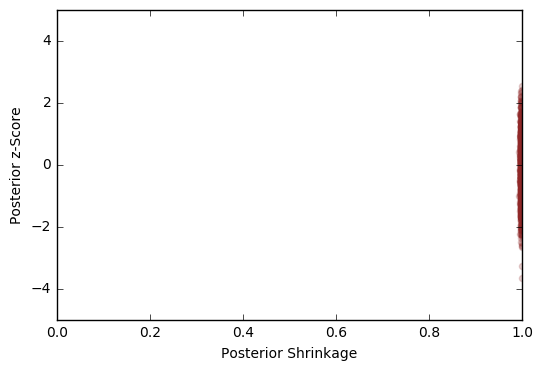

In [16]:
z_scores = [x[2] for x in ensemble_output]
shrinkages = [x[3] for x in ensemble_output]

plot.scatter(shrinkages, z_scores, color=dark, alpha=0.2)
plot.gca().set_xlabel("Posterior Shrinkage")
plot.gca().set_xlim(0, 1)
plot.gca().set_ylabel("Posterior z-Score")
plot.gca().set_ylim(-5, 5)

plot.show()

The fitted posteriors concentrate towards large shrinkages which indicates that 
all of our posteriors in the joint ensemble are well-identified.  Moreover, the
concentration towards small posterior $z$-scores indicates that they also
accurately capture the simulated model configurations.

#### Analyze Bespoke Model Sensitivity

Without an explicit decision or precise scientific question in mind we don't
have any bespoke model sensitivities to perform.  This would be different if we,
for example, were interested in identifying differences between the detectors 
or subtle phenomena in the source being observed.

### Step Seven: Fit the Observations and Evaluate

Confident that our model captures our domain expertise and is well-behaved
within the scope of its own assumptions we can fire up our email client and
grab the student's data.

In [17]:
data = pystan.read_rdump('workflow.data.R')

model = stan_utility.compile_model('fit_data_ppc.stan')
fit = model.sampling(data=data, seed=4838282)

Using cached StanModel


The fit shows no diagnostic problems,

In [18]:
stan_utility.check_all_diagnostics(fit)

n_eff / iter looks reasonable for all parameters
Rhat looks reasonable for all parameters
0.0 of 4000 iterations ended with a divergence (0.0%)
0 of 4000 iterations saturated the maximum tree depth of 10 (0%)
E-BFMI indicated no pathological behavior


and the recovered posterior for the source intensity looks reasonable.

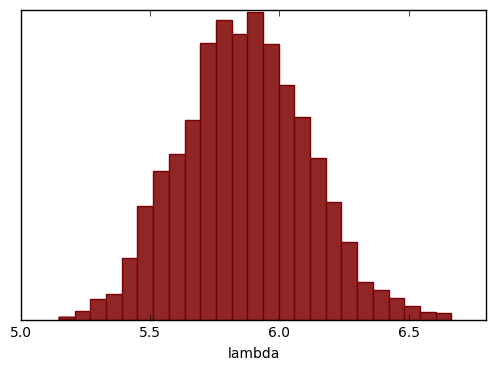

In [19]:
params = fit.extract()

plot.hist(params['lambda'], bins = 25, color = dark, ec = dark_highlight)
plot.gca().set_xlabel("lambda")
plot.gca().axes.get_yaxis().set_visible(False)
plot.show()

### Step Eight: Analyze the Posterior Predictive Distribution

But how well does our model capture the structure of the data?  To perform
a posterior predictive check we compare the observed histogram of counts to
the posterior predictive distribution of counts, here visualized with marginal
bin quantiles as we did for the prior predictive distribution.

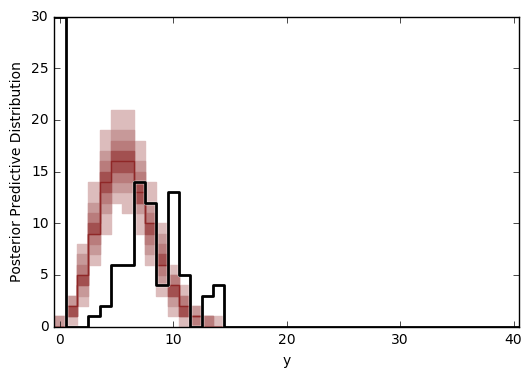

In [20]:
max_y = 40
B = max_y + 1

bins = [b - 0.5 for b in range(B + 1)]

idxs = [ idx for idx in range(B) for r in range(2) ]
xs = [ idx + delta for idx in range(B) for delta in [-0.5, 0.5]]
      
obs_counts = numpy.histogram(data['y'], bins=bins)[0]
pad_obs_counts = [ obs_counts[idx] for idx in idxs ]

counts = [numpy.histogram(params['y_ppc'][n], bins=bins)[0] for n in range(4000)]
probs = [10, 20, 30, 40, 50, 60, 70, 80, 90]
creds = [numpy.percentile([count[b] for count in counts], probs)
         for b in range(B)]
pad_creds = [ creds[idx] for idx in idxs ]

plot.fill_between(xs, [c[0] for c in pad_creds], [c[8] for c in pad_creds],
                  facecolor=light, color=light)
plot.fill_between(xs, [c[1] for c in pad_creds], [c[7] for c in pad_creds],
                  facecolor=light_highlight, color=light_highlight)
plot.fill_between(xs, [c[2] for c in pad_creds], [c[6] for c in pad_creds],
                  facecolor=mid, color=mid)
plot.fill_between(xs, [c[3] for c in pad_creds], [c[5] for c in pad_creds],
                  facecolor=mid_highlight, color=mid_highlight)
plot.plot(xs, [c[4] for c in pad_creds], color=dark)

plot.plot(xs, pad_obs_counts, linewidth=2.5, color="white")
plot.plot(xs, pad_obs_counts, linewidth=2.0, color="black")

plot.gca().set_xlim([min(bins), max(bins)])
plot.gca().set_xlabel("y")
plot.gca().set_ylim([0, max(max(obs_counts), max([c[8] for c in creds]))])
plot.gca().set_ylabel("Posterior Predictive Distribution")

plot.show()

Unfortunately the posterior predictive check indicates a serious excess of
zeros above what we'd expect from a Poissonian observational model alone.  Our 
model is not flexible enough to capture both the peak at zero and the bulk away 
from zero, instead trying to compromise between these two behaviors and 
failing to capturing either particularly well.  This experiment isn't quite as 
simple as it first appeared, but we can use the structure of this failure to
motivate an improved model and try again.

## Second Iteration: If At First You Don't Succeed, Try Try Again

The conflict between the observation and the model prediction we saw in the
posterior predictive check immediately suggests an expanded model where we 
introduce a second source of zeroes, and a second iteration of our workflow.

### Step One: Conceptual Analysis

Because we hadn't previously considered a source of excess zeroes we should
return all the way back to the conceptual analysis in order to understand the
possible mechanisms for these zeroes in our measurement process.  The excess
suggests that not all of the detectors are in perfect working order, returning
zero counts regardless of the flux of incident radiation.  Upon further 
consideration this isn't unreasonable for detectors that a student excavated
from a dusty closet.

### Step Two: Define Observations

The observation space does not change in our expanded model, just the 
probabilistic structure of our possible data generating processes.

### Step Three: Identify Relevant Summary Statistics

The same histogram summary will be useful in summarizing the observations.

### Step Four: Build a Model

We can readily capture this possibility of failing detectors with a 
_zero-inflated Poisson_ model that mixes a Poisson distribution with a point 
distribution that concentrates entirely at zero.  We use the same prior for the
source intensity, $\lambda$, and assign a uniform prior over the mixture weight,
$\theta$.

This expanded model is implemented in the Stan programs

In [21]:
with open('sample_joint_ensemble2.stan', 'r') as file:
    print(file.read())

data {
  int N;
}

generated quantities {
  // Simulate model configuration from prior model
  real<lower=0, upper=1> theta = beta_rng(1, 1);
  real<lower=0> lambda = fabs(normal_rng(0, 6.44787));
  
  // Simulate data from observational model
  int y[N] = rep_array(0, N);
  for (n in 1:N)
    if (!bernoulli_rng(theta))
      y[n] = poisson_rng(lambda);
}



In [22]:
with open('fit_data2.stan', 'r') as file:
    print(file.read())

data {
  int N;    // Number of observations
  int y[N]; // Count at each observation
}

parameters {
  real<lower=0, upper=1> theta; // Excess zero probability
  real<lower=0> lambda;         // Poisson intensity
}

model {
  // Prior model
  theta ~ beta(1, 1);
  lambda ~ normal(0, 6.44787);

  // Observational model that mixes a Poisson with excess zeros
  for (n in 1:N) {
    real lpdf = poisson_lpmf(y[n] | lambda);
    if (y[n] == 0)
      target += log_mix(theta, 0, lpdf);
    else
      target += log(1 - theta) + lpdf;
  }
}



### Step Five: Identify New Summary Statistics

Because zero-inflation manifests in the histogram summary statistic we don't
need a new summary statistic to isolate this behavior.  If we wanted to be
exhaustive, however, we could consider new summary statistics such as the 
number of observed zeros or the ratio of observed zeroes to total observations.

### Step Six: Analyze the Joint Ensemble

The structure of our joint ensemble doesn't change.

In [23]:
model = stan_utility.compile_model('sample_joint_ensemble2.stan')
fit = model.sampling(data=simu_data,
                     iter=R, warmup=0, chains=1, refresh=R,
                     seed=4838282, algorithm="Fixed_param")

simu_lambdas = fit.extract()['lambda']
simu_thetas = fit.extract()['theta']
simu_ys = fit.extract()['y'].astype(numpy.int64)

Using cached StanModel


####  Analyze the Prior Predictive Distribution

The prior predictive distribution of histograms now manifests the zero-inflation 
we have added to our model.

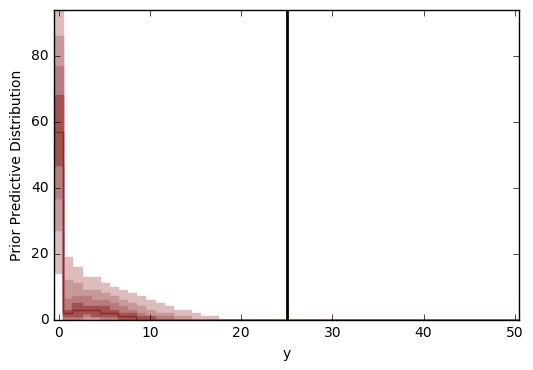

In [24]:
max_y = 50
B = max_y + 1

bins = [b - 0.5 for b in range(B + 1)]

counts = [numpy.histogram(simu_ys[r], bins=bins)[0] for r in range(R)]
probs = [10, 20, 30, 40, 50, 60, 70, 80, 90]
creds = [numpy.percentile([count[b] for count in counts], probs)
         for b in range(B)]

idxs = [ idx for idx in range(B) for r in range(2) ]
xs = [ idx + delta for idx in range(B) for delta in [-0.5, 0.5]]
      
pad_creds = [ creds[idx] for idx in idxs ]

plot.fill_between(xs, [c[0] for c in pad_creds], [c[8] for c in pad_creds],
                  facecolor=light, color=light)
plot.fill_between(xs, [c[1] for c in pad_creds], [c[7] for c in pad_creds],
                  facecolor=light_highlight, color=light_highlight)
plot.fill_between(xs, [c[2] for c in pad_creds], [c[6] for c in pad_creds],
                  facecolor=mid, color=mid)
plot.fill_between(xs, [c[3] for c in pad_creds], [c[5] for c in pad_creds],
                  facecolor=mid_highlight, color=mid_highlight)
plot.plot(xs, [c[4] for c in pad_creds], color=dark)

plot.gca().set_xlim([min(bins), max(bins)])
plot.gca().set_xlabel("y")
plot.gca().set_ylim([0, max([c[8] for c in creds])])
plot.gca().set_ylabel("Prior Predictive Distribution")

plot.axvline(x=25, linewidth=2.5, color="white")
plot.axvline(x=25, linewidth=2, color="black")

plot.show()

This addition, however, doesn't change the tail of observations and hence we
still have an appropriately small prior predictive probability for extreme
counts.

In [25]:
float(len([ y for y in simu_ys.flatten() if y > 25 ])) / len(simu_ys.flatten())

0.00038

There are fewer extreme counts than before because the zero inflation 
suppresses the relative number of non-zero observations.

#### Evaluate Simulated Fits

We proceed to fitting each replication, being sure to capture simulation 
based calibration ranks and posterior summaries for the new parameter.

In [26]:
simus = zip(simu_lambdas, simu_thetas, simu_ys)
fit_model = stan_utility.compile_model('fit_data2.stan')

def analyze_simu(simu):
    simu_l = simu[0]
    simu_t = simu[1]
    simu_y = simu[2]
    
    # Fit the simulated observation
    input_data = dict(N = N, y = simu_y)
    
    fit = fit_model.sampling(data=input_data, seed=4938483, n_jobs=1)
    
    # Compute diagnostics
    warning_code = stan_utility.check_all_diagnostics(fit, quiet=True)
    
    # Compute rank of prior draw with respect to thinned posterior draws
    thinned_l = fit.extract()['lambda'][numpy.arange(0, 4000 - 7, 8)]
    sbc_rank_l = len(list(filter(lambda x: x > simu_l, thinned_l)))
    
    thinned_t = fit.extract()['theta'][numpy.arange(0, 4000 - 7, 8)]
    sbc_rank_t = len(list(filter(lambda x: x > simu_t, thinned_t)))
    
    # Compute posterior sensitivities
    summary = fit.summary(pars="lambda", probs=[0.5])
    post_mean_l = [x[0] for x in summary['summary']][0]
    post_sd_l = [x[2] for x in summary['summary']][0]
    
    prior_sd_l = 6.44787
    
    z_score_l = (post_mean_l - simu_l) / post_sd_l
    shrinkage_l = 1 - (post_sd_l / prior_sd_l)**2
    
    summary = fit.summary(pars="theta", probs=[0.5])
    post_mean_t = [x[0] for x in summary['summary']][0]
    post_sd_t = [x[2] for x in summary['summary']][0]
    
    prior_sd_t = math.sqrt(1.0 / 12)
    
    z_score_t = (post_mean_t - simu_t) / post_sd_t
    shrinkage_t = 1 - (post_sd_t / prior_sd_t)**2
        
    return [warning_code, sbc_rank_l, z_score_l, shrinkage_l,
                          sbc_rank_t, z_score_t, shrinkage_t]

Using cached StanModel


In [27]:
pool = multiprocessing.Pool(4)
ensemble_output = pool.map(analyze_simu, simus)

First things first we check the fit diagnostics for each replication.

In [28]:
warning_codes = [x[0] for x in ensemble_output]
if sum(warning_codes) is not 0:
    print ("Some posterior fits in the generative " +
           "ensemble encountered problems!")
    for r in range(R):
        if warning_codes[r] is not 0:
            print('Replication {} of {}'.format(r, R))
            print('Simulated lambda = {}'.format(simu_lambdas[r]))
            print('Simulated theta = {}'.format(simu_thetas[r]))
            stan_utility.parse_warning_code(warning_codes[r])
            print("")
else:
    print ("No posterior fits in the generative " +
           "ensemble encountered problems!")

Some posterior fits in the generative ensemble encountered problems!
Replication 520 of 1000
Simulated lambda = 12.3507918959
Simulated theta = 0.127310630829
treedepth warning

Replication 551 of 1000
Simulated lambda = 12.5424015748
Simulated theta = 0.14390969243
treedepth warning

Replication 629 of 1000
Simulated lambda = 11.7285375341
Simulated theta = 0.874235662538
treedepth warning

Replication 748 of 1000
Simulated lambda = 14.7118484978
Simulated theta = 0.948596055573
treedepth warning



Unfortunately our computed fits are nowhere near as reliable for this expanded
model!  Indeed if we carefully analyze the simulated model configurations for 
each of the problematic fits we notice that problems arise whenever $\lambda$ is 
small or $\theta$ is large.  That seems a little suspicious, no?

It should, because this is a manifestation of a _non-identifiability_ hiding in
our zero-inflated model.  When the Poisson source strength is small enough the
resulting distribution will be indistinguishable from the distribution 
concentrated at zero that we are using to model the excess zeroes.

While we could try to reconfigure our computational method to better handle this
non-identifiability, its manifestation provides us with an opportunity to 
reconsider our domain expertise and tweak our model.  Is it reasonable for the
source intensity to be small enough that we would expect mostly zeroes from the
Poisson model?

Because computational problems correlate with extreme posterior behavior, they
have a knack for identifying the deficiency of the domain expertise we've
incorporated into our model.  We should heed their warnings carefully!

## Third Iteration: It's About the Journey, Not The Destination, Right?

Taking a deep breath we push on with our third iteration of the model building
workflow.

### Step One: Conceptual Analysis

Just how reasonable is it for a working detector aimed at a well-known source
to admit a small Poisson intensity, or for all of the detectors to be working
or not working?  The problems identified by the above computational problems 
identified some important questions that we hadn't addressed with our domain
expertise.  

Upon reflection let's say that our domain expertise specifies that the source
we're studying has been previously calibrated to test detectors like these so
that zero observations are rare for a working detector exposed to the source for
as long as ours were.  Moreover, while some of the detectors may be flakey, a 
bunch were recently used and so not all of them should be failing.  While our
observational model will not change, these recognitions imply more informative 
priors for the zero-inflated model.  Working detectors and malfunctioning
detectors should be distinguishable!

Importantly these insights were not learned from any observations.  They come 
from domain expertise that has always existed, if not within us then within our 
colleagues, but had not been incorporated into our model.  Only when 
computational problems identified pathological behaviors did we reevaluate and
expand our domain expertise.

### Step Two: Define Observations

The observation space remains the same.

### Step Three: Identify Relevant Summary Statistics

As does the utility of the histogram summary.

### Step Four: Build a Model

We need to introduce prior distributions that incorporate enough of our newly
considered domain expertise to separate the behavior of the working detectors 
and the malfunctioning detectors.  At the same time we have to be careful to 
avoid using the observed data to inform these prior distributions lest we 
introduce the potential for overfitting to that observation.  Instead we want to 
use the tension in the posterior predictive check to suggest an additional model 
component, here the zero-inflation, and then use our domain expertise to 
motivate appropriate prior distributions independent of the details of the 
observation itself.

We can tame the non-identifiability that is inconsistent with our domain
expertise by utilizing an inverse Gamma distribution that places only 1%
probability below $\lambda = 1$, where the Poisson distribution starts to look
like the distribution concentrated at zero that we're using to model the
malfunctioning detectors.  At the same time we want to maintain 1% of the prior 
probability above $\lambda = 15$.

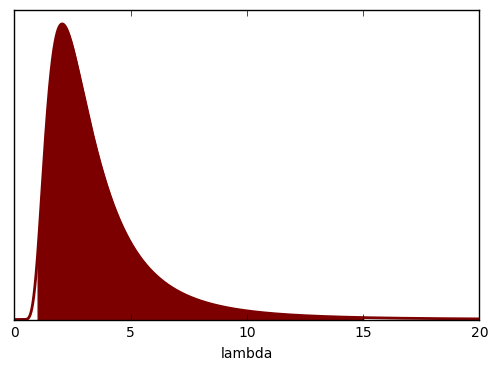

In [29]:
ls = numpy.arange(0, 20, 0.001)
pdfs = [ 9.21604**3.48681 * stats.invgamma.pdf(l / 9.21604 , 3.48681) 
        for l in ls]
plot.plot(ls, pdfs, linewidth=2, color=dark_highlight)

ls = numpy.arange(1, 15, 0.001)
pdfs = [ 9.21604**3.48681 * stats.invgamma.pdf(l / 9.21604 , 3.48681) 
        for l in ls]
plot.fill_between(ls, 0, pdfs, color=dark_highlight)

plot.gca().set_xlabel("lambda")
plot.gca().set_ylabel("Prior Density")
plot.gca().axes.get_yaxis().set_visible(False)
plot.show()

Additionally, let's take a prior distribution for the zero mixture probability,
$\theta$, that puts only 1% probability mass below 0.1 and above 0.9 to capture
our domain knowledge that some detectors are expected to fail but not all of
them.  Again, we want to be careful to not use the exact number of zeros in the
observed data to inform this prior distribution.

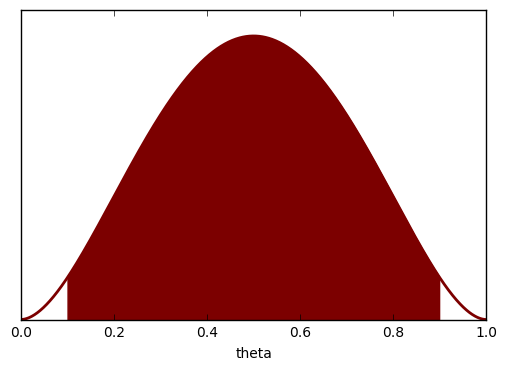

In [30]:
ts = numpy.arange(0, 1, 0.001)
pdfs = [ stats.beta.pdf(t, 2.8663, 2.8663) for t in ts]
plot.plot(ts, pdfs, linewidth=2, color=dark_highlight)

ts = numpy.arange(0.1, 0.9, 0.001)
pdfs = [ stats.beta.pdf(t, 2.8663, 2.8663) for t in ts]
plot.fill_between(ts, 0, pdfs, color=dark_highlight)

plot.gca().set_xlabel("theta")
plot.gca().set_ylabel("Prior Density")
plot.gca().axes.get_yaxis().set_visible(False)
plot.show()

The new model is implemented in the Stan programs

In [31]:
with open('sample_joint_ensemble3.stan', 'r') as file:
    print(file.read())

data {
  int N;
}

generated quantities {
  // Simulate model configuration from prior model
  real<lower=0, upper=1> theta = beta_rng(2.8663, 2.8663);
  real<lower=0> lambda = inv_gamma_rng(3.48681, 9.21604);
  
  // Simulate data from observational model
  int y[N] = rep_array(0, N);
  for (n in 1:N)
    if (!bernoulli_rng(theta))
      y[n] = poisson_rng(lambda);
}



In [32]:
with open('fit_data3.stan', 'r') as file:
    print(file.read())

data {
  int N;    // Number of observations
  int y[N]; // Count at each observation
}

parameters {
  real<lower=0, upper=1> theta; // Excess zero probability
  real<lower=0> lambda;         // Poisson intensity
}

model {
  // Prior model
  theta ~ beta(2.8663, 2.8663);
  lambda ~ inv_gamma(3.48681, 9.21604);

  // Observational model that mixes a Poisson with excess zeros
  for (n in 1:N) {
    real lpdf = poisson_lpmf(y[n] | lambda);
    if (y[n] == 0)
      target += log_mix(theta, 0, lpdf);
    else
      target += log(1 - theta) + lpdf;
  }
}



### Step Five: Identify New Summary Statistics

The histogram summary statistic is still capable of capturing the relevant
structure of the observations.

### Step Six: Analyze the Joint Ensemble

The joint ensemble is generated as before.

In [33]:
model = stan_utility.compile_model('sample_joint_ensemble3.stan')
fit = model.sampling(data=simu_data,
                     iter=R, warmup=0, chains=1, refresh=R,
                     seed=4838282, algorithm="Fixed_param")

simu_lambdas = fit.extract()['lambda']
simu_thetas = fit.extract()['theta']
simu_ys = fit.extract()['y'].astype(numpy.int64)

Using cached StanModel


#### Analyze the Prior Predictive Distribution

With the modified prior distributions we see a slightly different prior
predictive average histogram, but one still compatible with our domain
expertise.

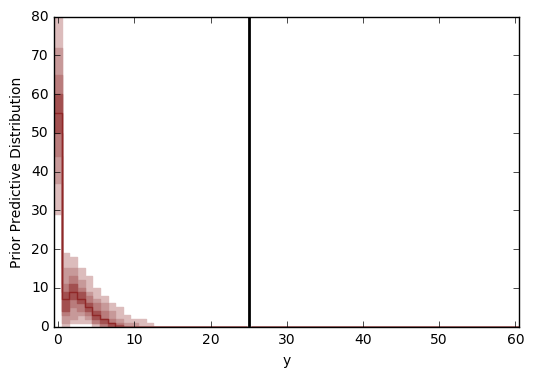

In [34]:
max_y = 60
B = max_y + 1

bins = [b - 0.5 for b in range(B + 1)]

counts = [numpy.histogram(simu_ys[r], bins=bins)[0] for r in range(R)]
probs = [10, 20, 30, 40, 50, 60, 70, 80, 90]
creds = [numpy.percentile([count[b] for count in counts], probs)
         for b in range(B)]

idxs = [ idx for idx in range(B) for r in range(2) ]
xs = [ idx + delta for idx in range(B) for delta in [-0.5, 0.5]]
      
pad_creds = [ creds[idx] for idx in idxs ]

plot.fill_between(xs, [c[0] for c in pad_creds], [c[8] for c in pad_creds],
                  facecolor=light, color=light)
plot.fill_between(xs, [c[1] for c in pad_creds], [c[7] for c in pad_creds],
                  facecolor=light_highlight, color=light_highlight)
plot.fill_between(xs, [c[2] for c in pad_creds], [c[6] for c in pad_creds],
                  facecolor=mid, color=mid)
plot.fill_between(xs, [c[3] for c in pad_creds], [c[5] for c in pad_creds],
                  facecolor=mid_highlight, color=mid_highlight)
plot.plot(xs, [c[4] for c in pad_creds], color=dark)

plot.gca().set_xlim([min(bins), max(bins)])
plot.gca().set_xlabel("y")
plot.gca().set_ylim([0, max([c[8] for c in creds])])
plot.gca().set_ylabel("Prior Predictive Distribution")

plot.axvline(x=25, linewidth=2.5, color="white")
plot.axvline(x=25, linewidth=2, color="black")

plot.show()

Indeed we have the desired low probability for extreme observations.

In [35]:
float(len([ y for y in simu_ys.flatten() if y > 25 ])) / len(simu_ys.flatten())

0.00249

#### Evaluate Simulated Fits

We can now proceed to fitting each replication, updating the posterior
shrinkage calculations to take into account the updated prior distributions.

### Step Five: Identify New Summary Statistics

Because zero-inflation manifests in the histogram summary statistic we don't
need a new summary statistic to isolate this behavior.  If we wanted to be
exhaustive, however, we could consider new summary statistics such as the 
number of observed zeros or the ratio of observed zeroes to total observations.

### Step Six: Analyze the Joint Ensemble

The structure of our joint ensemble doesn't change.

With the non-identifiability tempered there are no diagnostic indications of
fitting problems, save for a lone treedepth warming which denotes a slighty inefficiency but importantly no bias in our computation.

In [36]:
simus = zip(simu_lambdas, simu_thetas, simu_ys)
fit_model = stan_utility.compile_model('fit_data3.stan')

def analyze_simu(simu):
    simu_l = simu[0]
    simu_t = simu[1]
    simu_y = simu[2]
    
    # Fit the simulated observation
    input_data = dict(N = N, y = simu_y)
    
    fit = fit_model.sampling(data=input_data, seed=4938483, n_jobs=1)
    
    # Compute diagnostics
    warning_code = stan_utility.check_all_diagnostics(fit, quiet=True)
    
    # Compute rank of prior draw with respect to thinned posterior draws
    thinned_l = fit.extract()['lambda'][numpy.arange(0, 4000 - 7, 8)]
    sbc_rank_l = len(list(filter(lambda x: x > simu_l, thinned_l)))
    
    thinned_t = fit.extract()['theta'][numpy.arange(0, 4000 - 7, 8)]
    sbc_rank_t = len(list(filter(lambda x: x > simu_t, thinned_t)))
    
    # Compute posterior sensitivities
    summary = fit.summary(pars="lambda", probs=[0.5])
    post_mean_l = [x[0] for x in summary['summary']][0]
    post_sd_l = [x[2] for x in summary['summary']][0]
    
    prior_sd_l = math.sqrt( (9.21604)**2 / ((3.48681 - 1)**2 * (3.48681 - 1)) )
    
    z_score_l = (post_mean_l - simu_l) / post_sd_l
    shrinkage_l = 1 - (post_sd_l / prior_sd_l)**2
    
    summary = fit.summary(pars="theta", probs=[0.5])
    post_mean_t = [x[0] for x in summary['summary']][0]
    post_sd_t = [x[2] for x in summary['summary']][0]
    
    prior_sd_t = math.sqrt( (2.8663)**2 / (4 * (2.8663)**2 * (2 * 2.8663 + 1)) )
    
    z_score_t = (post_mean_t - simu_t) / post_sd_t
    shrinkage_t = 1 - (post_sd_t / prior_sd_t)**2
        
    return [warning_code, sbc_rank_l, z_score_l, shrinkage_l,
                          sbc_rank_t, z_score_t, shrinkage_t]


Using cached StanModel


In [37]:
pool = multiprocessing.Pool(4)
ensemble_output = pool.map(analyze_simu, simus)

In [38]:
warning_codes = [x[0] for x in ensemble_output]
if sum(warning_codes) is not 0:
    print ("Some posterior fits in the generative " +
           "ensemble encountered problems!")
    for r in range(R):
        if warning_codes[r] is not 0:
            print('Replication {} of {}'.format(r, R))
            print('Simulated lambda = {}'.format(simu_lambdas[r]))
            print('Simulated theta = {}'.format(simu_thetas[r]))
            stan_utility.parse_warning_code(warning_codes[r])
            print("")
else:
    print ("No posterior fits in the generative " +
           "ensemble encountered problems!")

Some posterior fits in the generative ensemble encountered problems!
Replication 998 of 1000
Simulated lambda = 11.6884737351
Simulated theta = 0.263512925907
treedepth warning



#### Implement Simulated-Based Calibration

Similarly, the simulation-based histograms for both $\lambda$ and $\theta$ show 
no signs of errors in our fits.

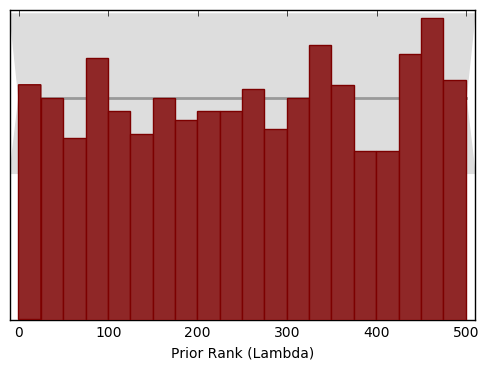

In [39]:
sbc_low = stats.binom.ppf(0.005, R, 25.0 / 500)
sbc_mid = stats.binom.ppf(0.5, R, 25.0 / 500)
sbc_high = stats.binom.ppf(0.995, R, 25.0 / 500)

bar_x = [-10, 510, 500, 510, -10, 0, -10]
bar_y = [sbc_high, sbc_high, sbc_mid, sbc_low, sbc_low, sbc_mid, sbc_high]

plot.fill(bar_x, bar_y, color="#DDDDDD", ec="#DDDDDD")
plot.plot([0, 500], [sbc_mid, sbc_mid], color="#999999", linewidth=2)

sbc_ranks = [x[1] for x in ensemble_output]

plot.hist(sbc_ranks, bins=[25 * x - 0.5 for x in range(21)],
          color=dark, ec=dark_highlight, zorder=3)

plot.gca().set_xlabel("Prior Rank (Lambda)")
plot.gca().set_xlim(-10, 510)
plot.gca().axes.get_yaxis().set_visible(False)

plot.show()

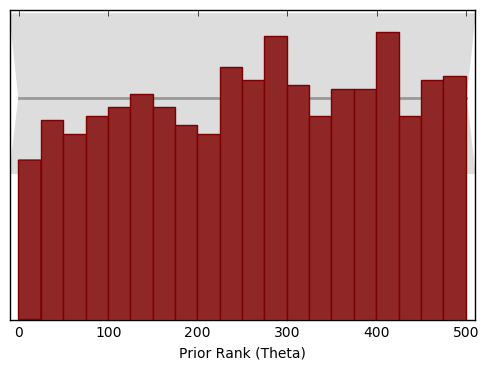

In [40]:
plot.fill(bar_x, bar_y, color="#DDDDDD", ec="#DDDDDD")
plot.plot([0, 500], [sbc_mid, sbc_mid], color="#999999", linewidth=2)

sbc_ranks = [x[4] for x in ensemble_output]

plot.hist(sbc_ranks, bins=[25 * x - 0.5 for x in range(21)],
          color=dark, ec=dark_highlight, zorder=3)

plot.gca().set_xlabel("Prior Rank (Theta)")
plot.gca().set_xlim(-10, 510)
plot.gca().axes.get_yaxis().set_visible(False)

plot.show()

#### Analyze General Model Sensitivity

This leaves us to check the ensemble behavior of our recovered posterior
distributions which looks reasonable for both parameters.

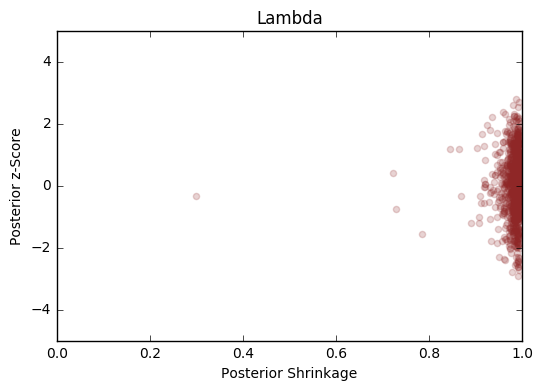

In [41]:
z_scores = [x[2] for x in ensemble_output]
shrinkages = [x[3] for x in ensemble_output]

plot.scatter(shrinkages, z_scores, color=dark, alpha=0.2)
plot.gca().set_xlabel("Posterior Shrinkage")
plot.gca().set_xlim(0, 1)
plot.gca().set_ylabel("Posterior z-Score")
plot.gca().set_ylim(-5, 5)
plot.title("Lambda")

plot.show()

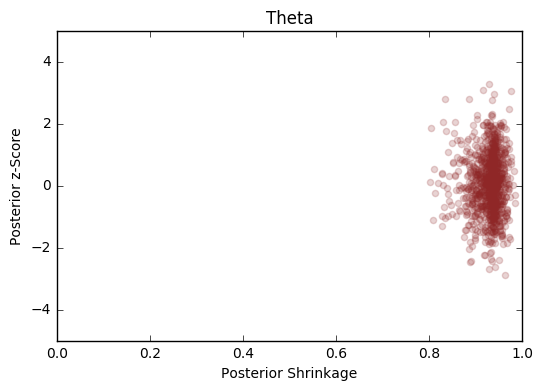

In [42]:
z_scores = [x[5] for x in ensemble_output]
shrinkages = [x[6] for x in ensemble_output]

plot.scatter(shrinkages, z_scores, color=dark, alpha=0.2)
plot.gca().set_xlabel("Posterior Shrinkage")
plot.gca().set_xlim(0, 1)
plot.gca().set_ylabel("Posterior z-Score")
plot.gca().set_ylim(-5, 5)
plot.title("Theta")

plot.show()


### Step Seven: Fit the Observations and Evaluate

Confident in the performance of the expanded model within the scope of its
own assumptions we go back to fit the observed data once again.

In [43]:
model = stan_utility.compile_model('fit_data3_ppc.stan')
fit = model.sampling(data=data, seed=4838282)

Using cached StanModel


The diagnostics look good,

In [44]:
stan_utility.check_all_diagnostics(fit)

n_eff / iter looks reasonable for all parameters
Rhat looks reasonable for all parameters
0.0 of 4000 iterations ended with a divergence (0.0%)
0 of 4000 iterations saturated the maximum tree depth of 10 (0%)
E-BFMI indicated no pathological behavior


and the marginal posterior distributions look reasonable.

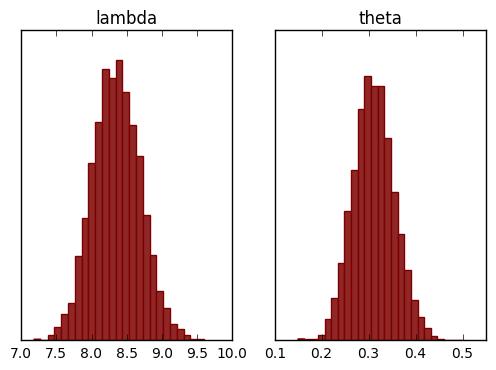

In [45]:
params = fit.extract()

f, axarr = plot.subplots(1, 2)
    
axarr[0].set_title("lambda")
axarr[0].hist(params['lambda'], bins = 25, color = dark, ec = dark_highlight)
axarr[0].get_yaxis().set_visible(False)

axarr[1].set_title("theta")
axarr[1].hist(params['theta'], bins = 25, color = dark, ec = dark_highlight)
axarr[1].get_yaxis().set_visible(False)

plot.show()

### Step Eight: Analyze the Posterior Predictive Distribution

Excited that we might finally have an adequate model we proceed to the
posterior predictive check.

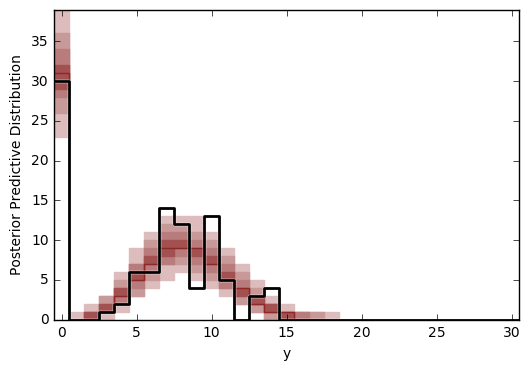

In [46]:
max_y = 30
B = max_y + 1

bins = [b - 0.5 for b in range(B + 1)]

idxs = [ idx for idx in range(B) for r in range(2) ]
xs = [ idx + delta for idx in range(B) for delta in [-0.5, 0.5]]
      
obs_counts = numpy.histogram(data['y'], bins=bins)[0]
pad_obs_counts = [ obs_counts[idx] for idx in idxs ]

counts = [numpy.histogram(params['y_ppc'][n], bins=bins)[0] for n in range(4000)]
probs = [10, 20, 30, 40, 50, 60, 70, 80, 90]
creds = [numpy.percentile([count[b] for count in counts], probs)
         for b in range(B)]

pad_creds = [ creds[idx] for idx in idxs ]

plot.fill_between(xs, [c[0] for c in pad_creds], [c[8] for c in pad_creds],
                  facecolor=light, color=light)
plot.fill_between(xs, [c[1] for c in pad_creds], [c[7] for c in pad_creds],
                  facecolor=light_highlight, color=light_highlight)
plot.fill_between(xs, [c[2] for c in pad_creds], [c[6] for c in pad_creds],
                  facecolor=mid, color=mid)
plot.fill_between(xs, [c[3] for c in pad_creds], [c[5] for c in pad_creds],
                  facecolor=mid_highlight, color=mid_highlight)
plot.plot(xs, [c[4] for c in pad_creds], color=dark)

plot.plot(xs, pad_obs_counts, linewidth=2.5, color="white")
plot.plot(xs, pad_obs_counts, linewidth=2.0, color="black")

plot.gca().set_xlim([min(bins), max(bins)])
plot.gca().set_xlabel("y")
plot.gca().set_ylim([0, max(max(obs_counts), max([c[8] for c in creds]))])
plot.gca().set_ylabel("Posterior Predictive Distribution")

plot.show()

Frustratingly we see that the tail of the posterior predictive histogram seems to extend
beyond that in the observed data.  This suggests that the detector responses may be truncated and unable to record values above $y = 14$.  At this point we are slightly suspicious of the exact measurement process but don't have enough domain expertise to suggest an expanded model with any confidence.  Before considering any expansions we need to consult with the one person who was there.

## Fourth Iteration: Coffee Is For Closers

A principled analysis workflow is a powerful investigatory tool for identifying
subtle structure in the observed data and motivating appropriate model features.
There is a fine line, however, between improving the model and overfitting to
the given observation.  To avoid crossing this line we have to lean on our
domain expertise, and sometimess the domain expertise of others.

### Step One: Conceptual Analysis

Suspicious of the experimental setup under which the data were collected we ask
to meet with the student who ran the experiment.  When we bring up the odd
behavior we saw the student seems nonchalant.  "Oh, you mean like when the
detectors didn't read out anything at all?" they say. "I just repeated the
measurement for each detector until they reported an actual value." they say.

And there it is.  The readout system for detectors seems to be vulnerable to
overloading when the counts surpass a given value, returning no value at all.
When the student repeated the measurement for detectors in this state they
unintentionally induced a _truncated observation_ where the Poisson distribution
is cutoff at a certain value.

### Step Two: Define Observations

The observation space does not change.

### Step Three: Identify Relevant Summary Statistics

The same histogram summary remains appropriate.

### Step Four: Build a Model

We now have to augment out observational model to account for the truncation of
the counts.  Ideally we would treat the truncation threshold as a systematic
parameter here and infer it with uncertainties to avoid overfitting to our one
observation.  Unfortunately that model is a bit ungainly, so for pedagogical
simplification we will take the fixed threshold of $y = 14$ implied by the
observed data assuming that it too is consistent with our hypothetical domain
expertise.

In [47]:
with open('sample_joint_ensemble4.stan', 'r') as file:
    print(file.read())

data {
  int N;
}

transformed data {
  int U = 14;
}

generated quantities {
  // Simulate model configuration from prior model
  real<lower=0, upper=1> theta = beta_rng(2.8663, 2.8663);
  real<lower=0> lambda = inv_gamma_rng(3.48681, 9.21604);

  // Simulate data from observational model
  int y[N] = rep_array(0, N);
  for (n in 1:N) {
    if (!bernoulli_rng(theta)) {
      real sum_p = 0;
      real u = uniform_rng(0, 1);

      for (b in 0:U) {
        sum_p = sum_p + exp(poisson_lpmf(b | lambda) - poisson_lcdf(U | lambda));
        if (sum_p >= u) {
          y[n] = b;
          break;
        }
      }
    }
  }
}



In [48]:
with open('fit_data4.stan', 'r') as file:
    print(file.read())

data {
  int N;    // Number of observations
  int y[N]; // Count at each observation
}

transformed data {
  int U = 14;  // Observational cutoff
}

parameters {
  real<lower=0, upper=1> theta; // Excess zero probability
  real<lower=0> lambda;         // Poisson intensity
}

model {
  // Prior model
  theta ~ beta(2.8663, 2.8663);
  lambda ~ inv_gamma(3.48681, 9.21604);

  // Observational model that mixes a truncated Poisson with excess zeros
  for (n in 1:N) {
    real lpdf = poisson_lpmf(y[n] | lambda) - poisson_lcdf(U | lambda);
    if (y[n] == 0)
      target += log_mix(theta, 0, lpdf);
    else
      target += log(1 - theta) + lpdf;
  }
}



### Step Five: Identify New Summary Statistics

Truncation already manifests in the histogram summary statistic so it remains
sufficient to capture the relevant structure of the data.

### Step Six: Analyze the Joint Ensemble

We dutifully generate the joint ensemble of our expanded model.

In [49]:
model = stan_utility.compile_model('sample_joint_ensemble4.stan')
fit = model.sampling(data=simu_data,
                     iter=R, warmup=0, chains=1, refresh=1000,
                     seed=558483, algorithm="Fixed_param")

simu_lambdas = fit.extract()['lambda']
simu_thetas = fit.extract()['theta']
simu_ys = fit.extract()['y'].astype(numpy.int64)

Using cached StanModel


#### Analyze the Prior Predictive Distribution

The prior predictive distribution of histograms now exhibits both zero-inflation 
and truncation.

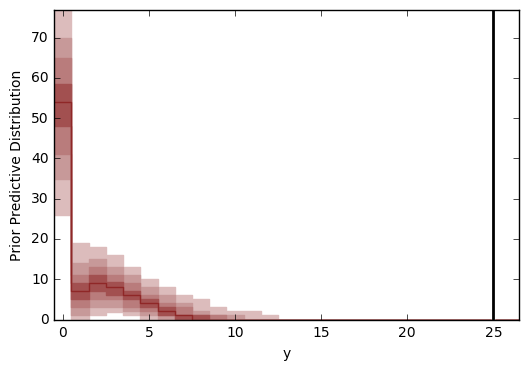

In [50]:
max_y = 26
B = max_y + 1

bins = [b - 0.5 for b in range(B + 1)]

counts = [numpy.histogram(simu_ys[r], bins=bins)[0] for r in range(R)]
probs = [10, 20, 30, 40, 50, 60, 70, 80, 90]
creds = [numpy.percentile([count[b] for count in counts], probs)
         for b in range(B)]

idxs = [ idx for idx in range(B) for r in range(2) ]
xs = [ idx + delta for idx in range(B) for delta in [-0.5, 0.5]]
      
pad_creds = [ creds[idx] for idx in idxs ]

plot.fill_between(xs, [c[0] for c in pad_creds], [c[8] for c in pad_creds],
                  facecolor=light, color=light)
plot.fill_between(xs, [c[1] for c in pad_creds], [c[7] for c in pad_creds],
                  facecolor=light_highlight, color=light_highlight)
plot.fill_between(xs, [c[2] for c in pad_creds], [c[6] for c in pad_creds],
                  facecolor=mid, color=mid)
plot.fill_between(xs, [c[3] for c in pad_creds], [c[5] for c in pad_creds],
                  facecolor=mid_highlight, color=mid_highlight)
plot.plot(xs, [c[4] for c in pad_creds], color=dark)

plot.gca().set_xlim([min(bins), max(bins)])
plot.gca().set_xlabel("y")
plot.gca().set_ylim([0, max([c[8] for c in creds])])
plot.gca().set_ylabel("Prior Predictive Distribution")

plot.axvline(x=25, linewidth=2.5, color="white")
plot.axvline(x=25, linewidth=2, color="black")

plot.show()

With the truncation we now have exactly zero prior predictive probability above
the extreme observation scale derived from our domain expertise.

In [51]:
float(len([ y for y in simu_ys.flatten() if y > 25 ])) / len(simu_ys.flatten())

0.0

#### Evaluate Simulated Fits

We continue to fitting each replication in our joint ensemble.

In [52]:
simus = zip(simu_lambdas, simu_thetas, simu_ys)
fit_model = stan_utility.compile_model('fit_data4.stan')

def analyze_simu(simu):
    simu_l = simu[0]
    simu_t = simu[1]
    simu_y = simu[2]
    
    # Fit the simulated observation
    input_data = dict(N = N, y = simu_y)
    
    fit = fit_model.sampling(data=input_data, seed=4938483, n_jobs=1)
    
    # Compute diagnostics
    warning_code = stan_utility.check_all_diagnostics(fit, quiet=True)
    
    # Compute rank of prior draw with respect to thinned posterior draws
    thinned_l = fit.extract()['lambda'][numpy.arange(0, 4000 - 7, 8)]
    sbc_rank_l = len(list(filter(lambda x: x > simu_l, thinned_l)))
    
    thinned_t = fit.extract()['theta'][numpy.arange(0, 4000 - 7, 8)]
    sbc_rank_t = len(list(filter(lambda x: x > simu_t, thinned_t)))
    
    # Compute posterior sensitivities
    summary = fit.summary(pars="lambda", probs=[0.5])
    post_mean_l = [x[0] for x in summary['summary']][0]
    post_sd_l = [x[2] for x in summary['summary']][0]
    
    prior_sd_l = math.sqrt( (9.21604)**2 / ((3.48681 - 1)**2 * (3.48681 - 1)) )
    
    z_score_l = (post_mean_l - simu_l) / post_sd_l
    shrinkage_l = 1 - (post_sd_l / prior_sd_l)**2
    
    summary = fit.summary(pars="theta", probs=[0.5])
    post_mean_t = [x[0] for x in summary['summary']][0]
    post_sd_t = [x[2] for x in summary['summary']][0]
    
    prior_sd_t = math.sqrt( (2.8663)**2 / (4 * (2.8663)**2 * (2 * 2.8663 + 1)) )
    
    z_score_t = (post_mean_t - simu_t) / post_sd_t
    shrinkage_t = 1 - (post_sd_t / prior_sd_t)**2
        
    return [warning_code, sbc_rank_l, z_score_l, shrinkage_l,
                          sbc_rank_t, z_score_t, shrinkage_t]

Using cached StanModel


In [53]:
pool = multiprocessing.Pool(4)
ensemble_output = pool.map(analyze_simu, simus)

Happily, the diagnostics all look clean.

In [54]:
warning_codes = [x[0] for x in ensemble_output]
if sum(warning_codes) is not 0:
    print ("Some posterior fits in the generative " +
           "ensemble encountered problems!")
    for r in range(R):
        if warning_codes[r] is not 0:
            print('Replication {} of {}'.format(r, R))
            print('Simulated lambda = {}'.format(simu_lambdas[r]))
            print('Simulated theta = {}'.format(simu_thetas[r]))
            stan_utility.parse_warning_code(warning_codes[r])
            print("")
else:
    print ("No posterior fits in the generative " +
           "ensemble encountered problems!")

Some posterior fits in the generative ensemble encountered problems!
Replication 916 of 1000
Simulated lambda = 13.7193347196
Simulated theta = 0.333694368053
treedepth warning



#### Implement Simulated-Based Calibration

Similarly the simulation-based calibration histograms exhibit no problematic
behavior.

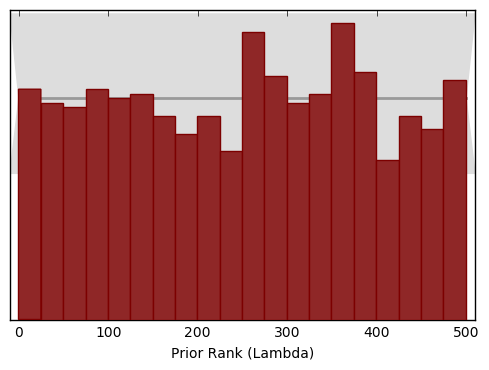

In [55]:
sbc_low = stats.binom.ppf(0.005, R, 25.0 / 500)
sbc_mid = stats.binom.ppf(0.5, R, 25.0 / 500)
sbc_high = stats.binom.ppf(0.995, R, 25.0 / 500)

bar_x = [-10, 510, 500, 510, -10, 0, -10]
bar_y = [sbc_high, sbc_high, sbc_mid, sbc_low, sbc_low, sbc_mid, sbc_high]

plot.fill(bar_x, bar_y, color="#DDDDDD", ec="#DDDDDD")
plot.plot([0, 500], [sbc_mid, sbc_mid], color="#999999", linewidth=2)

sbc_ranks = [x[1] for x in ensemble_output]

plot.hist(sbc_ranks, bins=[25 * x - 0.5 for x in range(21)],
          color=dark, ec=dark_highlight, zorder=3)

plot.gca().set_xlabel("Prior Rank (Lambda)")
plot.gca().set_xlim(-10, 510)
plot.gca().axes.get_yaxis().set_visible(False)

plot.show()

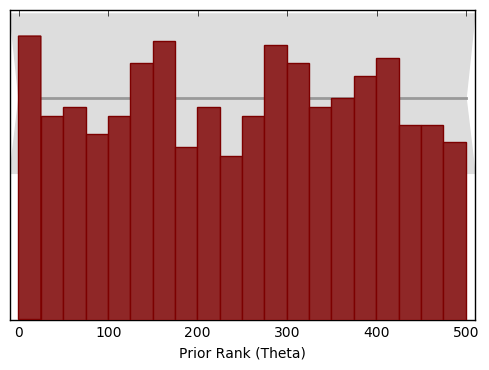

In [56]:
plot.fill(bar_x, bar_y, color="#DDDDDD", ec="#DDDDDD")
plot.plot([0, 500], [sbc_mid, sbc_mid], color="#999999", linewidth=2)

sbc_ranks = [x[4] for x in ensemble_output]

plot.hist(sbc_ranks, bins=[25 * x - 0.5 for x in range(21)],
          color=dark, ec=dark_highlight, zorder=3)

plot.gca().set_xlabel("Prior Rank (Theta)")
plot.gca().set_xlim(-10, 510)
plot.gca().axes.get_yaxis().set_visible(False)

plot.show()

Moreover, the recovered posteriors for each fit perform reasonable well.

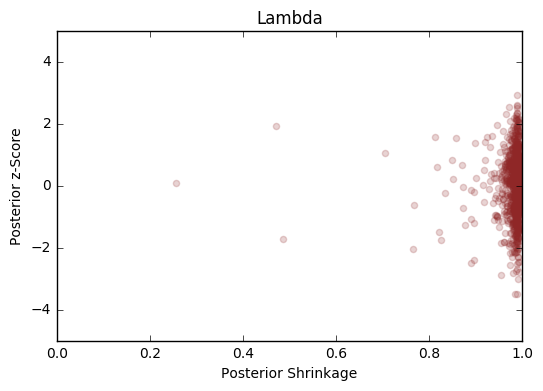

In [57]:
z_scores = [x[2] for x in ensemble_output]
shrinkages = [x[3] for x in ensemble_output]

plot.scatter(shrinkages, z_scores, color=dark, alpha=0.2)
plot.gca().set_xlabel("Posterior Shrinkage")
plot.gca().set_xlim(0, 1)
plot.gca().set_ylabel("Posterior z-Score")
plot.gca().set_ylim(-5, 5)
plot.title("Lambda")

plot.show()

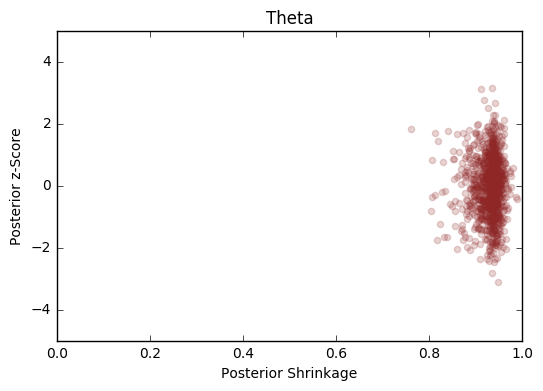

In [58]:
z_scores = [x[5] for x in ensemble_output]
shrinkages = [x[6] for x in ensemble_output]

plot.scatter(shrinkages, z_scores, color=dark, alpha=0.2)
plot.gca().set_xlabel("Posterior Shrinkage")
plot.gca().set_xlim(0, 1)
plot.gca().set_ylabel("Posterior z-Score")
plot.gca().set_ylim(-5, 5)
plot.title("Theta")

plot.show()

### Step Seven: Fit the Observations and Evaluate

Exhausted, we march on to fit the observed data.

In [59]:
model = stan_utility.compile_model('fit_data4_ppc.stan')
fit = model.sampling(data=data, seed=4838282)

Using cached StanModel


The diagnostics are clean,

In [60]:
stan_utility.check_all_diagnostics(fit)

n_eff / iter looks reasonable for all parameters
Rhat looks reasonable for all parameters
0.0 of 4000 iterations ended with a divergence (0.0%)
0 of 4000 iterations saturated the maximum tree depth of 10 (0%)
E-BFMI indicated no pathological behavior


and the marginal posteriors are reasonable.

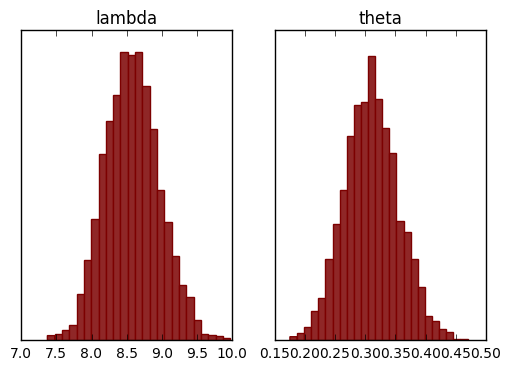

In [61]:
params = fit.extract()

f, axarr = plot.subplots(1, 2)
    
axarr[0].set_title("lambda")
axarr[0].hist(params['lambda'], bins = 25, color = dark, ec = dark_highlight)
axarr[0].get_yaxis().set_visible(False)

axarr[1].set_title("theta")
axarr[1].hist(params['theta'], bins = 25, color = dark, ec = dark_highlight)
axarr[1].get_yaxis().set_visible(False)

plot.show()

### Step Eight: Analyze the Posterior Predictive Distribution

Anxiously we move on to the posterior predictive check.

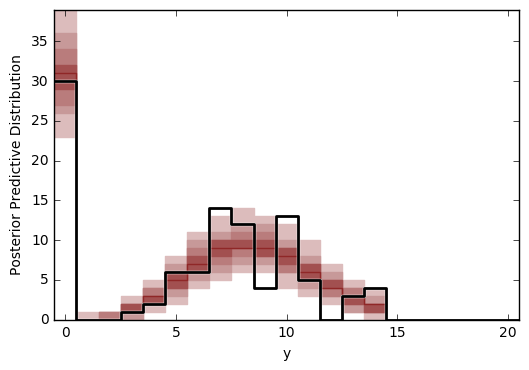

In [62]:
max_y = 20
B = max_y + 1

bins = [b - 0.5 for b in range(B + 1)]

idxs = [ idx for idx in range(B) for r in range(2) ]
xs = [ idx + delta for idx in range(B) for delta in [-0.5, 0.5]]
      
obs_counts = numpy.histogram(data['y'], bins=bins)[0]
pad_obs_counts = [ obs_counts[idx] for idx in idxs ]

counts = [numpy.histogram(params['y_ppc'][n], bins=bins)[0] for n in range(4000)]
probs = [10, 20, 30, 40, 50, 60, 70, 80, 90]
creds = [numpy.percentile([count[b] for count in counts], probs)
         for b in range(B)]

pad_creds = [ creds[idx] for idx in idxs ]

plot.fill_between(xs, [c[0] for c in pad_creds], [c[8] for c in pad_creds],
                  facecolor=light, color=light)
plot.fill_between(xs, [c[1] for c in pad_creds], [c[7] for c in pad_creds],
                  facecolor=light_highlight, color=light_highlight)
plot.fill_between(xs, [c[2] for c in pad_creds], [c[6] for c in pad_creds],
                  facecolor=mid, color=mid)
plot.fill_between(xs, [c[3] for c in pad_creds], [c[5] for c in pad_creds],
                  facecolor=mid_highlight, color=mid_highlight)
plot.plot(xs, [c[4] for c in pad_creds], color=dark)

plot.plot(xs, pad_obs_counts, linewidth=2.5, color="white")
plot.plot(xs, pad_obs_counts, linewidth=2.0, color="black")

plot.gca().set_xlim([min(bins), max(bins)])
plot.gca().set_xlabel("y")
plot.gca().set_ylim([0, max(max(obs_counts), max([c[8] for c in creds]))])
plot.gca().set_ylabel("Posterior Predictive Distribution")

plot.show()

And finally we see no tension between the observed data and the posterior 
predictive distribution.  After a few attempts we have a model that captures the 
intricacies of our observed data!

Satisfied in our detector detective work we send out the results to our
colleagues and start drafting a note instructing students what to do when the
detectors do not report any counts at all.

# Discussion

By very carefully following a principled Bayesian workflow we were able to
answer the questions proposed in [Section Two](#Questioning-Authority) and develop a
model that incorporates enough domain expertise to achieve a reasonable fit to
our observed data.  Indeed the progression of the workflow itself helped to
inform which domain expertise we need to incorporate, and in particular when we
needed to follow up with colleagues to better understand the circumstances of
the experiment.  By minding this domain expertise, and not simply fitting to the
potentially irrelevant details of the observed data, we ensured a final model
that is robust to overfitting and should generalize well to application on new
observations.

That said, this workflow makes no claim that the final model is correct in any
absolute sense.  Our ability to critique the model is limited by the specific
questions we ask and the information encoded in the observed data.  Indeed more
thorough questions or additional data might demonstrate limitations of our
concluding model and the need for further iterations.  Our detectors, for
example, may not have identical responses, and those individual responses may 
not be so static in time.  Similarly the source being measured may not emit 
particles uniformly in time or space.  A principled workflow doesn't yield the 
correct model but rather a model that meets the needs of a given inferential 
task.

While the workflow is structured, it is not automatic and requires careful and
customized consideration of the available domain expertise in the scope of the 
modeling assumptions at each step.  Moreover the workflow isn't cheap, requiring
significant computational resources to fully exploit it even on this relatively
simple example.  That investment of time and resources, however, provides a
powerful model robust to many of the pathologies that can lead to biased
inferences and faulty scientific insights.

# Acknowledgements

I thank Sean Talts, Marc Dotson, and Tomi Peltola for helpful comments and 
and Justin Bois for critical help with some of the Python code.  Specak thanks
are in order for everyone who offered feedback after attending my courses and 
talks.

A very special thanks to everyone supporting me on Patreon: Aki Vehtari, Austin 
Rochford, Bo Schwartz Madsen, Cat Shark, Charles Naylor, Colin Carroll, Daniel 
Simpson, David Pascall, David Roher, Elad Berkman, Finn Lindgren, Granville 
Matheson, Hernan Bruno, J Michael Burgess, Joel Kronander, Jonas Beltoft 
Gehrlein, Joshua Mayer, Justin Bois, Lars Barquist, Marek Kwiatkowski,
Maurits van der Meer, Maxim Kesin, Michael Dillon, Ole Rogeberg, Oscar Olvera,
Riccardo Fusaroli, Richard Torkar, Sam Petulla, Sam Zorowitz, Seo-young Kim,
Seth Axen, Simon Duane, Stephen Oates, Stijn, and Vladislavs Dovgalecs.

# References

Betancourt, Michael. 2015. “A Unified Treatment of Predictive Model Comparison,” June.

———. 2018. “Calibrating Model-Based Inferences and Decisions,” March.

Gabry, Jonah, Daniel Simpson, Aki Vehtari, Michael Betancourt, and Andrew Gelman. 2017. “Visualization in Bayesian Workflow,” September.

Gelman, Andrew, Daniel Simpson, and Michael Betancourt. 2017. “The Prior Can Generally Only Be Understood in the Context of the Likelihood,” August.

Good, I.J. 1950. Probability and the Weighing of Evidence. New York: Hafners.

Rubin, Donald B. 1984. “Bayesianly Justifiable and Relevant Frequency Calculations for the Applied Statistician.” Ann. Statist. 12 (4): 1151–72.

Simpson, Daniel, Håvard Rue, Andrea Riebler, Thiago G. Martins, and Sigrunn H. Sørbye. 2017. “Penalising Model Component Complexity: A Principled, Practical Approach to Constructing Priors.” Statist. Sci. 32 (1): 1–28.

Talts, Sean, Michael Betancourt, Daniel Simpson, Aki Vehtari, and Andrew Gelman. 2018. “Validating Bayesian Inference Algorithms with Simulation-Based Calibration,” April.